# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
#helper
def save(model, filename):
    import pickle
    pickle.dump(model, open(filename,'wb'))

def load(filename):
    import pickle
    return pickle.load(open(filename, 'rb'))

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(5)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
#missing values count
azdias.isnull().sum()


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [7]:
#feat_nfo
with pd.option_context("display.max_rows", 100):
    display(feat_info)

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

In [8]:
#Check whether the attribute name is the same with azdias columns name
(feat_info['attribute'] != azdias.columns).sum()

0

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
def parse_missing(miss):
    #input from feat_info['missing_or_unknown']
    import ast
    try:
        #perform evaluation on numbers (int or string)
        result = ast.literal_eval(miss)
       
    except:
        #if not number, it means it is a alphabet like 'XX'
        result = miss.strip("[]")
        result = result.split(",")
        result = [ast.literal_eval(i) if i.lstrip('-').isdigit() else i for i in result]
    return result

#apply parse missing to col missing_or_unknown
feat_info['parse_missing_or_unknown'] =feat_info['missing_or_unknown'].apply(parse_missing)

In [6]:
#feat_nfo
with pd.option_context("display.max_rows", 100):
    display(feat_info)

attribute information_level         type missing_or_unknown  \
0                AGER_TYP            person  categorical             [-1,0]   
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]   
2               ANREDE_KZ            person  categorical             [-1,0]   
3           CJT_GESAMTTYP            person  categorical                [0]   
4       FINANZ_MINIMALIST            person      ordinal               [-1]   
5           FINANZ_SPARER            person      ordinal               [-1]   
6        FINANZ_VORSORGER            person      ordinal               [-1]   
7          FINANZ_ANLEGER            person      ordinal               [-1]   
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]   
9        FINANZ_HAUSBAUER            person      ordinal               [-1]   
10              FINANZTYP            person  categorical               [-1]   
11            GEBURTSJAHR            person      numeric                [0]   
12        GFK_URLAUBERTYP            person  categorical                 []   
13       GREEN_AVANTGARDE            person  categorical                 []   
14             HEALTH_TYP            person      ordinal             [-1,0]   
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]   
16    LP_LEBENSPHASE_GROB            person        mixed                [0]   
17        LP_FAMILIE_FEIN            person  categorical                [0]   
18        LP_FAMILIE_GROB            person  categorical                [0]   
19         LP_STATUS_FEIN            person  categorical                [0]   
20         LP_STATUS_GROB            person  categorical                [0]   
21       NATIONALITAET_KZ            person  categorical             [-1,0]   
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]   
23         RETOURTYP_BK_S            person      ordinal                [0]   
24              SEMIO_SOZ            person      ordinal             [-1,9]   
25              SEMIO_FAM            person      ordinal             [-1,9]   
26              SEMIO_REL            person      ordinal             [-1,9]   
27              SEMIO_MAT            person      ordinal             [-1,9]   
28             SEMIO_VERT            person      ordinal             [-1,9]   
29             SEMIO_LUST            person      ordinal             [-1,9]   
30              SEMIO_ERL            person      ordinal             [-1,9]   
31             SEMIO_KULT            person      ordinal             [-1,9]   
32              SEMIO_RAT            person      ordinal             [-1,9]   
33             SEMIO_KRIT            person      ordinal             [-1,9]   
34              SEMIO_DOM            person      ordinal             [-1,9]   
35             SEMIO_KAEM            person      ordinal             [-1,9]   
36          SEMIO_PFLICHT            person      ordinal             [-1,9]   
37            SEMIO_TRADV            person      ordinal             [-1,9]   
38            SHOPPER_TYP            person  categorical               [-1]   
39                SOHO_KZ            person  categorical               [-1]   
40               TITEL_KZ            person  categorical             [-1,0]   
41               VERS_TYP            person  categorical               [-1]   
42               ZABEOTYP            person  categorical             [-1,9]   
43               ALTER_HH         household     interval                [0]   
44           ANZ_PERSONEN         household      numeric                 []   
45              ANZ_TITEL         household      numeric                 []   
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]   
47           KK_KUNDENTYP         household  categorical               [-1]   
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]   
49         WOHNDAUER_2008         household      ordinal          

In [7]:
#copy azdias
azdias_ = azdias.copy()

#store azdias column names for numeric and object dtype.
#numeric and object dtype will be preprocessed separately

obj_cols = [col for col  in azdias_.columns if azdias_[col].dtype == object]
num_cols = [ col for col in azdias_.columns if col not in obj_cols]

#Processing NaN for numeric columns
for num_col in num_cols:
    nans = feat_info[feat_info['attribute'] ==num_col]['parse_missing_or_unknown'].values[0]
    for nan in nans:
        azdias_.loc[azdias_[num_col] == nan ,num_col] = np.nan
        
#Processing NaN for object columns
for obj_col in obj_cols:
    nans = feat_info[feat_info['attribute'] ==obj_col]['parse_missing_or_unknown'].values[0]
    for nan in nans:
        azdias_.loc[azdias_[obj_col] == str(nan) ,obj_col] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
#create null_df
null_count = azdias_.isnull().sum()
null_df = pd.DataFrame()
null_df['attribute'] = null_count.index
null_df['Null Count'] = null_count.values
null_df = pd.merge(null_df, feat_info,how='left', on='attribute')

In [9]:
with pd.option_context("display.max_rows", 100):
    display(null_df)

attribute  Null Count information_level         type  \
0                AGER_TYP      685843            person  categorical   
1    ALTERSKATEGORIE_GROB        2881            person      ordinal   
2               ANREDE_KZ           0            person  categorical   
3           CJT_GESAMTTYP        4854            person  categorical   
4       FINANZ_MINIMALIST           0            person      ordinal   
5           FINANZ_SPARER           0            person      ordinal   
6        FINANZ_VORSORGER           0            person      ordinal   
7          FINANZ_ANLEGER           0            person      ordinal   
8   FINANZ_UNAUFFAELLIGER           0            person      ordinal   
9        FINANZ_HAUSBAUER           0            person      ordinal   
10              FINANZTYP           0            person  categorical   
11            GEBURTSJAHR      392318            person      numeric   
12        GFK_URLAUBERTYP        4854            person  categorical   
13       GREEN_AVANTGARDE           0            person  categorical   
14             HEALTH_TYP      111196            person      ordinal   
15    LP_LEBENSPHASE_FEIN       97632            person        mixed   
16    LP_LEBENSPHASE_GROB       94572            person        mixed   
17        LP_FAMILIE_FEIN       77792            person  categorical   
18        LP_FAMILIE_GROB       77792            person  categorical   
19         LP_STATUS_FEIN        4854            person  categorical   
20         LP_STATUS_GROB        4854            person  categorical   
21       NATIONALITAET_KZ      108315            person  categorical   
22  PRAEGENDE_JUGENDJAHRE      108164            person        mixed   
23         RETOURTYP_BK_S        4854            person      ordinal   
24              SEMIO_SOZ           0            person      ordinal   
25              SEMIO_FAM           0            person      ordinal   
26              SEMIO_REL           0            person      ordinal   
27              SEMIO_MAT           0            person      ordinal   
28             SEMIO_VERT           0            person      ordinal   
29             SEMIO_LUST           0            person      ordinal   
30              SEMIO_ERL           0            person      ordinal   
31             SEMIO_KULT           0            person      ordinal   
32              SEMIO_RAT           0            person      ordinal   
33             SEMIO_KRIT           0            person      ordinal   
34              SEMIO_DOM           0            person      ordinal   
35             SEMIO_KAEM           0            person      ordinal   
36          SEMIO_PFLICHT           0            person      ordinal   
37            SEMIO_TRADV           0            person      ordinal   
38            SHOPPER_TYP      111196            person  categorical   
39                SOHO_KZ       73499            person  categorical   
40               TITEL_KZ      889061            person  categorical   
41               VERS_TYP      111196            person  categorical   
42               ZABEOTYP           0            person  categorical   
43               ALTER_HH      310267         household     interval   
44           ANZ_PERSONEN       73499         household      numeric   
45              ANZ_TITEL       73499         household      numeric   
46     HH_EINKOMMEN_SCORE       18348         household      ordinal   
47           KK_KUNDENTYP      584612         household  categorical   
48         W_KEIT_KIND_HH      147988         household      ordinal   
49         WOHNDAUER_2008       73499         household      ordinal   
50    ANZ_HAUSHALTE_AKTIV       99611          building      numeric   
51           ANZ_HH_TITEL       97008          building      numeric   
52            GEBAEUDETYP       93148          building  categorical   
53            KONSUMNAEHE       73969          building      ordinal   
54       MIN_GEBAEUDEJAHR       93148          building 

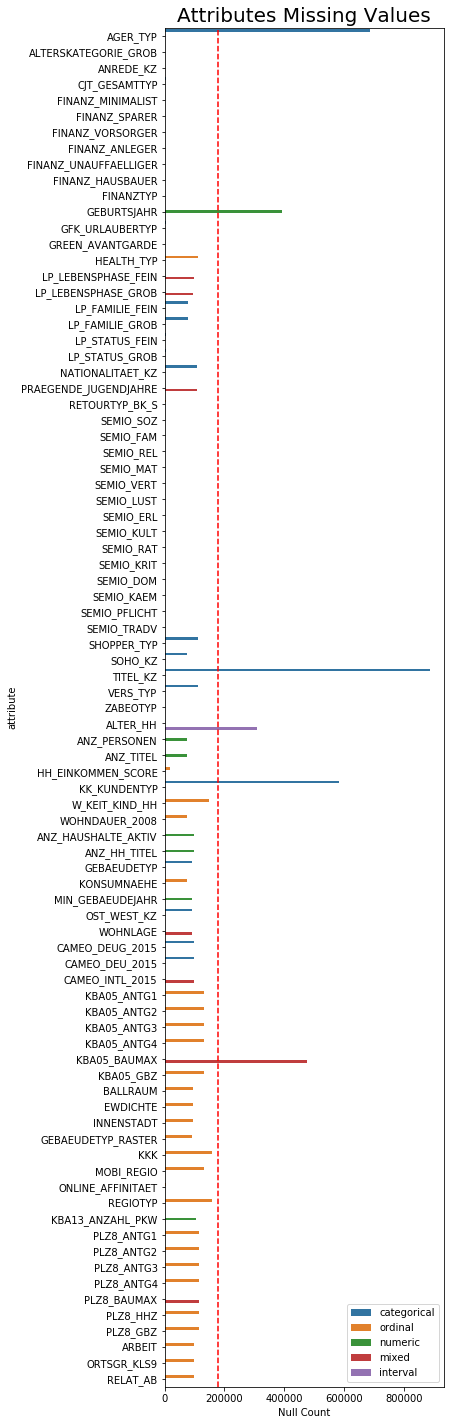

In [10]:
# Visualization of how much missing data there is in each column of the dataset.

f,ax = plt.subplots(figsize=(5,25))
ax = sns.barplot('Null Count','attribute', hue='type', data=null_df)

#set a vertical line 20% of data as threshold
ax.axvline(0.2*azdias_.shape[0], color='r', linestyle='dashed')

plt.legend()
ax.set_title('Attributes Missing Values', fontsize=20)

plt.show()

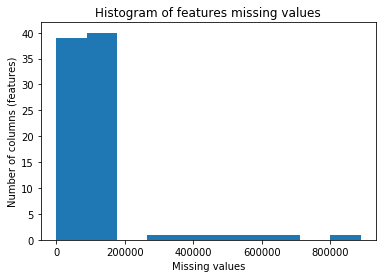

In [11]:
#histogram of attributes missing value counts
plt.hist(azdias_.isnull().sum(axis=0))
plt.title('Histogram of features missing values')
plt.xlabel('Missing values')
plt.ylabel('Number of columns (features)')
plt.show()

In [12]:
#drop columns that have more than 20% or 200,000 missing values
null_count[null_count > 200000].index

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [13]:
cols_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX']
azdias_ = azdias_.drop(cols_to_remove, axis=1)

In [14]:
azdias_.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most missing value in columns related to 'ordinal' and 'categorical'. The missing values count are similar within the same features group.

I decide to remove all features / columns that have  more than 200k (up to 20%) missing values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

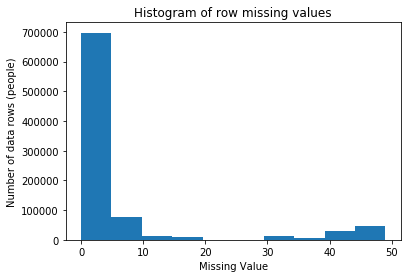

In [15]:
# How much data is missing in each row of the dataset?

row_null = azdias_.isnull().sum(axis=1)
plt.hist(row_null)
plt.xlabel('Missing Value')
plt.ylabel('Number of data rows (people)')
plt.title('Histogram of row missing values')
plt.show()

In [16]:
#number of data that have missing values more than 30 features
row_null[row_null > 20].shape[0] 

93795

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def dist_compare(attribute, threshold, data):
    row_null = data.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1 = sns.countplot(attribute, data=data[row_null< threshold], ax=ax1)
    ax2 = sns.countplot(attribute, data=data[row_null >= threshold], ax=ax2)
    ax1.set_title('missing value < '+ str(threshold) )
    ax2.set_title('missing value >= '+ str(threshold) )
    f.suptitle('Feature: ' + attribute)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

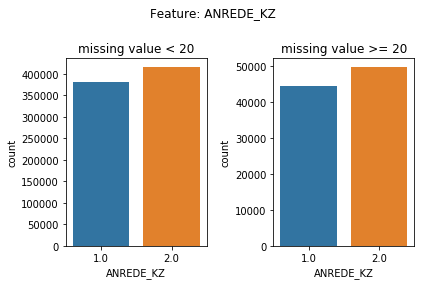

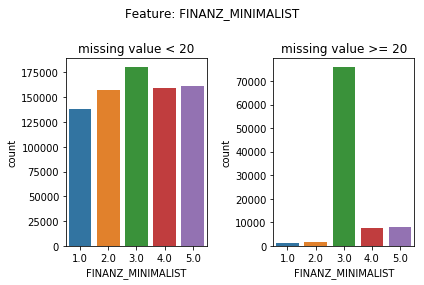

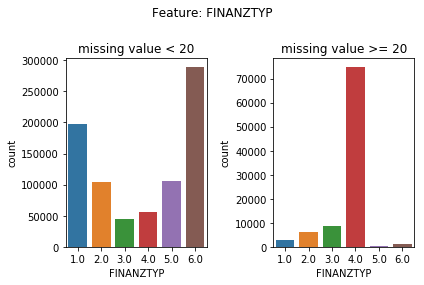

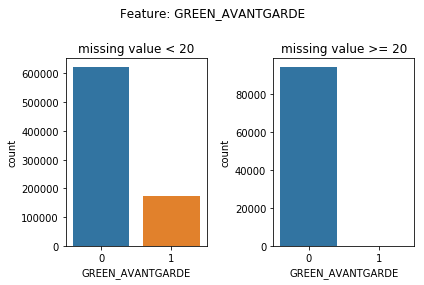

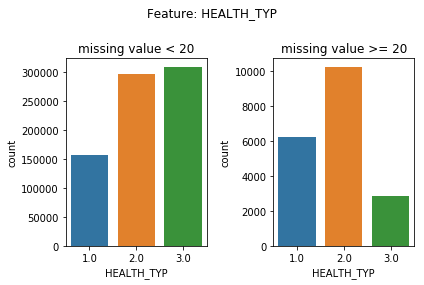

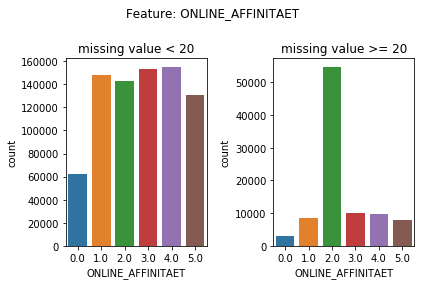

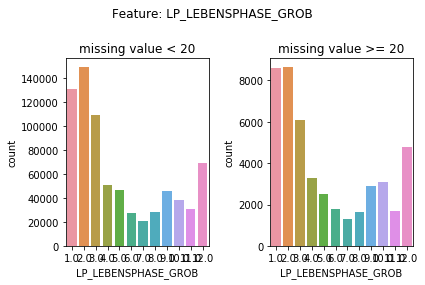

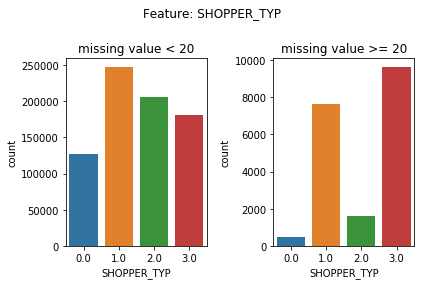

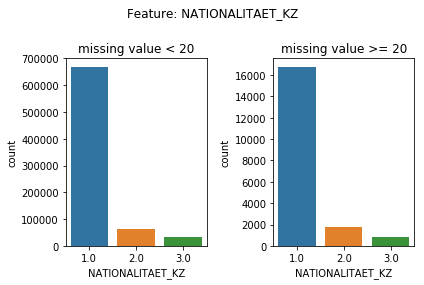

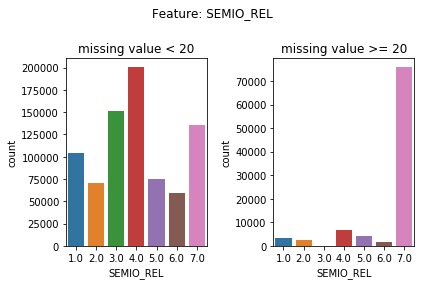

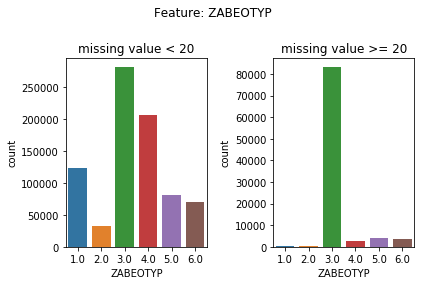

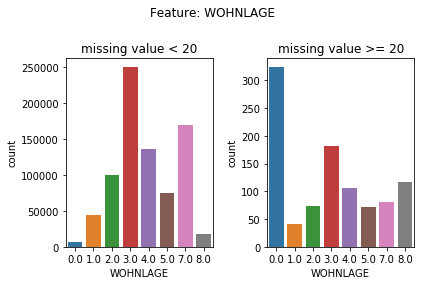

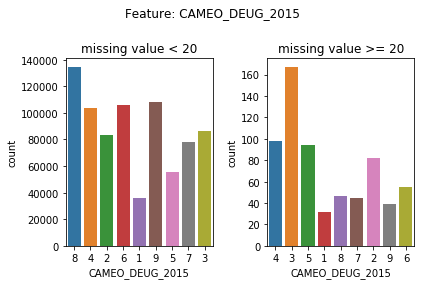

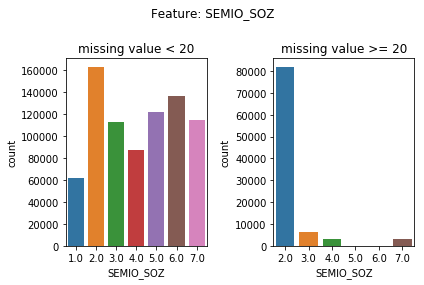

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

cols_to_compare = ['ANREDE_KZ','FINANZ_MINIMALIST','FINANZTYP','GREEN_AVANTGARDE','HEALTH_TYP',
                   'ONLINE_AFFINITAET','LP_LEBENSPHASE_GROB','SHOPPER_TYP','NATIONALITAET_KZ',
                   'SEMIO_REL','ZABEOTYP','WOHNLAGE','CAMEO_DEUG_2015', 
                  'SEMIO_SOZ']
for col in cols_to_compare:
    dist_compare(col, 20, azdias_)

In [19]:
#only keep row that less than or equal to 20 missing values
azdias_ = azdias_[row_null <= 20]

#### Discussion 1.1.3: Assess Missing Data in Each Row

There are 93k data that missing more than 20 features.

From 14 features comparison above, there are likely that data with lots of missing values (mor than 20 missing values) may qualitatively different from data with few missing values (with up to 20 missing values) as their distribution are different. So, I decided to keep row with missing values less than 20 rows and also keep separately other rows with lots missing values as special data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

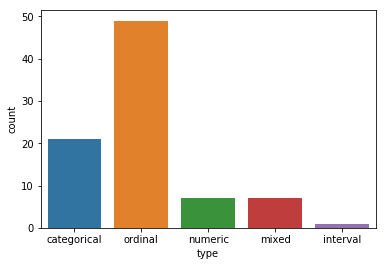

In [21]:
# How many features are there of each data type?
sns.countplot('type', data=feat_info)


In [22]:
#store feat_info that are categorical in cat_info variable
cat_info = feat_info[(feat_info['type'] == 'categorical') & (~feat_info['attribute'].isin(cols_to_remove))]
cat_info

attribute information_level         type missing_or_unknown  \
2          ANREDE_KZ            person  categorical             [-1,0]   
3      CJT_GESAMTTYP            person  categorical                [0]   
10         FINANZTYP            person  categorical               [-1]   
12   GFK_URLAUBERTYP            person  categorical                 []   
13  GREEN_AVANTGARDE            person  categorical                 []   
17   LP_FAMILIE_FEIN            person  categorical                [0]   
18   LP_FAMILIE_GROB            person  categorical                [0]   
19    LP_STATUS_FEIN            person  categorical                [0]   
20    LP_STATUS_GROB            person  categorical                [0]   
21  NATIONALITAET_KZ            person  categorical             [-1,0]   
38       SHOPPER_TYP            person  categorical               [-1]   
39           SOHO_KZ            person  categorical               [-1]   
41          VERS_TYP            person  categorical               [-1]   
42          ZABEOTYP            person  categorical             [-1,9]   
52       GEBAEUDETYP          building  categorical             [-1,0]   
55       OST_WEST_KZ          building  categorical               [-1]   
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]   
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]   

   parse_missing_or_unknown  
2                   [-1, 0]  
3                       [0]  
10                     [-1]  
12                       []  
13                       []  
17                      [0]  
18                      [0]  
19                      [0]  
20                      [0]  
21                  [-1, 0]  
38                     [-1]  
39                     [-1]  
41                     [-1]  
42                  [-1, 9]  
52                  [-1, 0]  
55                     [-1]  
57                  [-1, X]  
58                     [XX]

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#list of categorical feature that are object dtypes, for e.g "W", "O", "2A"
cat_non_numeric = list(azdias_[cat_info['attribute']].select_dtypes(['object']).columns)

#list of categorical features that are int /float dtypes for e.g 1,2,3,4, etc
cat_numeric = [ cat for cat in cat_info['attribute'] if cat not in cat_non_numeric]

#list categorical features that are binary for e.g 1,0 or 1,2
cat_binary = [cat for cat in cat_numeric if (len([x for x in azdias_[cat].unique() if not pd.isnull(x)]) ==  2)]

#list of categorcal features that are multi level.
cat_multi = [cat for cat in cat_numeric if cat not in cat_binary]

#list of categorical features that will be onehot encoded
to_onehot = cat_non_numeric + cat_multi

print('Categorical Feature - non-numeric  :\n {}'.format(cat_non_numeric))
print('\nCategorical Feature - binary:\n {}'.format(cat_binary))
print('\nCategorical Feature - multi level :\n {}'.format(cat_multi))
print('\nCategorical Features that will be encoded (onehot) :\n {}'.format(to_onehot))

Categorical Feature - non-numeric  :
 ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Categorical Feature - binary:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

Categorical Feature - multi level :
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP']

Categorical Features that will be encoded (onehot) :
 ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP']


In [47]:
# Re-encode categorical variable(s) to be kept in the analysis.
#keeping missing value as dummy

azdias_onehot = pd.get_dummies(azdias_,columns=to_onehot, dummy_na=True)


In [28]:
#shape after onehot
azdias_onehot.shape

(797426, 209)

In [29]:
#shape before onehot
azdias_.shape

(797426, 79)

In [61]:
azdias_onehot

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0        2.0                1.0            5.0   
2                        3.0        2.0                1.0            4.0   
3                        4.0        2.0                4.0            2.0   
4                        3.0        1.0                4.0            3.0   
5                        1.0        2.0                3.0            1.0   
6                        2.0        2.0                1.0            5.0   
7                        1.0        1.0                3.0            3.0   
8                        3.0        1.0                4.0            4.0   
9                        3.0        2.0                2.0            4.0   
10                       3.0        2.0                2.0            2.0   
12                       3.0        1.0                5.0            3.0   
13                       1.0        2.0                1.0            4.0   
15                       4.0        2.0                4.0            1.0   
16                       1.0        2.0                4.0            3.0   
18                       2.0        2.0                2.0            4.0   
19                       3.0        1.0                5.0            2.0   
20                       2.0        2.0                4.0            3.0   
21                       2.0        1.0                3.0            4.0   
22                       1.0        1.0                1.0            5.0   
23                       3.0        1.0                5.0            3.0   
25                       1.0        1.0                3.0            5.0   
26                       3.0        1.0                5.0            2.0   
27                       3.0        1.0                3.0            3.0   
28                       3.0        1.0                3.0            2.0   
29                       4.0        2.0                5.0            1.0   
31                       2.0        2.0                1.0            5.0   
32                       1.0        1.0                5.0            4.0   
33                       2.0        2.0                2.0            2.0   
34                       1.0        2.0                4.0            1.0   
36                       3.0        2.0                2.0            3.0   
...                      ...        ...                ...            ...   
891191                   4.0        2.0                4.0            1.0   
891192                   1.0        2.0                1.0            5.0   
891193                   4.0        1.0                4.0            1.0   
891194                   3.0        1.0                4.0            3.0   
891195                   4.0        2.0                3.0            1.0   
891196                   2.0        2.0                1.0            5.0   
891197                   3.0        2.0                3.0            2.0   
891198                   3.0        1.0                2.0            5.0   
891199                   2.0        1.0                2.0            5.0   
891200                   1.0        2.0                1.0            5.0   
891201                   3.0        1.0                4.0            2.0   
891202                   2.0        2.0                1.0            4.0   
891203                   4.0        2.0                4.0            1.0   
891204                   3.0        1.0                4.0            3.0   
891205                   4.0        1.0                4.0            2.0   
891206                   1.0        2.0                3.0            4.0   
891207                   3.0        2.0                5.0            1.0   
891208                   4.0        1.0                5.0            2.0   
891209                   1.0        2.0                1.0            4.0   
891210                   3.0        1.0                3.0            3.0   
8912

#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical features consists of 2 major type, categorical that are numeric value and non numeric value. The categorical numeric value type consist of binary (two-level) and multi-level. Using feature info data, these list of features are generated.

The onehot encoded using multiple dummy variables (pd.get_dummies) was applied to non-numeric & numeric multi-level categorical features. No columns are dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [5]:
feat_info[feat_info['type'] == 'mixed']

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#DECADE variable
decade_dict = {1: 1, 2:1,
              3:2, 4:2,
              5:3, 6:3, 7:3,
              8:4, 9:4,
              10:5, 11:5, 12:5,13:5,
              14:6, 15:6}

decade = azdias_onehot['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)

#MOVEMENT variable
# 0 = Mainstream, 1= Avantgarde
mainstream = [1,3,5, 8, 10, 12, 14]
avantgarde = [x for x in range(1,16,) if x not in mainstream]
movement = azdias_onehot['PRAEGENDE_JUGENDJAHRE'].copy()
movement[movement.isin(mainstream)] = 0
movement[movement.isin(avantgarde)] = 1

# new PRAEGENDE_JUGENDJAHRE variable
azdias_onehot = azdias_onehot.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
azdias_onehot['PRAEGENDE_JUGENDJAHRE_decade'] = decade
azdias_onehot['PRAEGENDE_JUGENDJAHRE_movement'] = movement


In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

cameo_list = [x for x in azdias_onehot['CAMEO_INTL_2015'].unique() if not pd.isnull(x)]

wealth = azdias_onehot['CAMEO_INTL_2015'].copy()
life_stage = azdias_onehot['CAMEO_INTL_2015'].copy()

for val in cameo_list:
    #val is a string of 2 digits for e.g '51'
    #separate 2 digits val, '51' --> ['5','1']
    val_ = list(str(val))
    
    #assign first digit to wealth 
    wealth[wealth == val] = val_[0]
    
    #assign second digit to life_stage
    life_stage[life_stage == val] = val_[1]
    
# new PRAEGENDE_JUGENDJAHRE variable
azdias_onehot = azdias_onehot.drop('CAMEO_INTL_2015', axis=1)
azdias_onehot['CAMEO_INTL_2015_wealth'] = wealth
azdias_onehot['CAMEO_INTL_2015_life_stage'] = life_stage  


In [50]:
"""
WOHNLAGE
- only to keep neighbourhood quality. Rural flag was removed as it contained more than 60% missing values, much higher than
neighbourhood quality which was only 19% missing values

Neigbourhood quality (ORDINAL)
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7 & 8 ==> change to np.nan
"""

neigh_dict = {7: np.nan, 8: np.nan}
neigh = azdias_onehot['WOHNLAGE'].replace(neigh_dict)

#drop WOHNLAGE
azdias_onehot = azdias_onehot.drop('WOHNLAGE', axis=1)

#add new variable
azdias_onehot['WOHNLAGE_neigh'] = neigh


#### Notes:
LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB will be dropped as they contained life stage, family type, and wealth, that were already included in LP_FAMILIE_FEIN, LP_STATUS_FEIN, LP_STATUS_GROB.

KBA05_BAUMAX & PLZ8_BAUMAX are actually a ordinal type rather than a mixed type. So I will keep it.

In [51]:
#drop  LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB

azdias_onehot = azdias_onehot.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)


In [52]:
azdias_onehot.shape

(797426, 209)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

Feature selection completed, no further processing 


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [4]:
def clean_data(df, feat_info, one_hot_cols=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, Summary of feature attributes
    OUTPUT: Trimmed and cleaned demographics DataFrame
           - df with data less than or equal to 20 missing values
           - df_special with data more than 20 missing values
           - one_hot_cols, will be used for customer data
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = convert_missing_value(df, feat_info)
    
    #keep columns that no more than 800k missing values : 'TITLE_KZ'
    cols_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX']
    
    df = df.drop(cols_to_remove, axis=1) 
    
    #remove row null more than 5
    row_null = df.isnull().sum(axis=1)
        
    if not one_hot_cols:
        #get columns to one hot
        one_hot_cols = one_hot_columns(df, feat_info, cols_to_remove)
    
    #perform onehot to one_hot_cols
    df = pd.get_dummies(df,columns=one_hot_cols) #, dummy_na=True)
       
    # engineer column values for mixed type feature attribute.
    df = encode(df)
    
    #mark special df with row missing values more than 20
    df_special = df[row_null > 20]
    df = df[row_null <= 20]
    
    # Return the cleaned dataframe 
    return df, df_special, one_hot_cols
    
def parse_missing(miss):
    #input from feat_info['missing_or_unknown']
    import ast
    try:
        #perform evaluation on numbers (int or string)
        result = ast.literal_eval(miss)
       
    except:
        #if not number, it means it is a alphabet like 'XX'
        result = miss.strip("[]")
        result = result.split(",")
        result = [ast.literal_eval(i) if i.lstrip('-').isdigit() else i for i in result]
    return result
   
def convert_missing_value(df, feat_info):   
    #apply parse missing to col missing_or_unknown
    feat_info['parse_missing_or_unknown'] =feat_info['missing_or_unknown'].apply(parse_missing)
    
    #copy df
    df_clean = df.copy()

    #numeric and object dtype will be preprocessed separately

    obj_cols = [col for col  in df_clean.columns if df_clean[col].dtype == object]
    num_cols = [ col for col in df_clean.columns if col not in obj_cols]

    #Processing NaN for numeric columns
    for num_col in num_cols:
        nans = feat_info[feat_info['attribute'] ==num_col]['parse_missing_or_unknown'].values[0]
        for nan in nans:
            df_clean.loc[df_clean[num_col] == nan ,num_col] = np.nan

    #Processing NaN for object columns
    for obj_col in obj_cols:
        nans = feat_info[feat_info['attribute'] ==obj_col]['parse_missing_or_unknown'].values[0]
        for nan in nans:
            df_clean.loc[df_clean[obj_col] == str(nan) ,obj_col] = np.nan
    
    return df_clean

def one_hot_columns(df, feat_info, cols_to_remove):
    """
    INPUT : df shall be parsed for missing value
    OUTPUT : list of columns to one-hot encoded
    """
    
    
    #build like feat_info but only to store 'categorical' type
    cat_info = feat_info[(feat_info['type'] == 'categorical') & (~feat_info['attribute'].isin(cols_to_remove))]
    
    #categorical consist of 2 types : categorical with a string/object and with integers value
    
    #get list of columns that are categorical type with object dtype such as 6A, W, E etc
    cat_non_numeric = list(df[cat_info['attribute']].select_dtypes(['object']).columns)
    
    #get list of columns that are categorical type with int dtype like 1,2,3,4,5
    cat_numeric = [ cat for cat in cat_info['attribute'] if cat not in cat_non_numeric]
    
    #get cols with binary categorical & int --> left is as is, not to one hot
    cat_numeric_binary = [cat for cat in cat_numeric if (len([x for x in df[cat].unique() if not pd.isnull(x)]) ==  2)]
    
    #get cols that not binary categorical 
    cat_numeric_multi = [cat for cat in cat_numeric if cat not in cat_numeric_binary]
    
    # cols to onehot 
    to_onehot = cat_non_numeric + cat_numeric_multi
    
    return to_onehot


def encode(df):
    """
    Perform the following : 
    - Binary value standardization (0,1) for ANREDE_KZ & VERS_TYP
    - encoding on PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015, WOHNLAGE and engineer new variables
    - Drop column 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'
    
    INPUT - Dataframe
    OUTPUT - encoded Dataframe 
    """
    #enconde ANREDE_KZ & VERS_TYP for binary standardization,
    # orginal : [1,2]  --> to [1,0]
    df['ANREDE_KZ'] = df['ANREDE_KZ'].replace({2:0})
    df['VERS_TYP'] = df['VERS_TYP'].replace({2:0})
    
    #Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    #DECADE variable mapping to new variable
    decade_dict = {1: 1, 2:1,
                  3:2, 4:2,
                  5:3, 6:3, 7:3,
                  8:4, 9:4,
                  10:5, 11:5, 12:5,13:5,
                  14:6, 15:6}

    decade = df['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)

    #MOVEMENT variable
    # 0 = Mainstream, 1= Avantgarde
    mainstream = [1,3,5, 8, 10, 12, 14]
    avantgarde = [x for x in range(1,16,) if x not in mainstream]
    movement = df['PRAEGENDE_JUGENDJAHRE'].copy()
    movement[movement.isin(mainstream)] = 0
    movement[movement.isin(avantgarde)] = 1

    # new PRAEGENDE_JUGENDJAHRE variable
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    df['PRAEGENDE_JUGENDJAHRE_decade'] = decade
    df['PRAEGENDE_JUGENDJAHRE_movement'] = movement
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    cameo_list = [x for x in df['CAMEO_INTL_2015'].unique() if not pd.isnull(x)]
    wealth = df['CAMEO_INTL_2015'].copy()
    life_stage = df['CAMEO_INTL_2015'].copy()

    for val in cameo_list:
        val_ = list(str(val))
        wealth[wealth == val] = val_[0]
        life_stage[life_stage == val] = val_[1]

    # new PRAEGENDE_JUGENDJAHRE variable
    df = df.drop('CAMEO_INTL_2015', axis=1)
    df['CAMEO_INTL_2015_wealth'] = wealth
    df['CAMEO_INTL_2015_life_stage'] = life_stage  

    #drop  LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB
    df = df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)

    #WOHNLAGE --> only to keep neighbourhood quality
    neigh_dict = {7: np.nan, 8: np.nan}
    neigh = df['WOHNLAGE'].replace(neigh_dict)
    #drop WOHNLAGE
    df = df.drop('WOHNLAGE', axis=1)
    #add new variable
    df['WOHNLAGE_neigh'] = neigh
    
    return df

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')



In [6]:
azdias_clean, azdias_clean_sp, one_hot_cols = clean_data(azdias, feat_info)

In [11]:
azdias_clean.shape

(797426, 195)

In [12]:
azdias_clean_sp.shape

(93795, 195)

In [7]:
save(one_hot_cols, 'one_hot_cols.txt')
one_hot_cols

['OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP']

In [8]:
with pd.option_context("display.max_columns", 300):
    display(azdias_clean)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0        0.0                1.0            5.0   
2                        3.0        0.0                1.0            4.0   
3                        4.0        0.0                4.0            2.0   
4                        3.0        1.0                4.0            3.0   
5                        1.0        0.0                3.0            1.0   
6                        2.0        0.0                1.0            5.0   
7                        1.0        1.0                3.0            3.0   
8                        3.0        1.0                4.0            4.0   
9                        3.0        0.0                2.0            4.0   
10                       3.0        0.0                2.0            2.0   
12                       3.0        1.0                5.0            3.0   
13                       1.0        0.0                1.0            4.0   
15                       4.0        0.0                4.0            1.0   
16                       1.0        0.0                4.0            3.0   
18                       2.0        0.0                2.0            4.0   
19                       3.0        1.0                5.0            2.0   
20                       2.0        0.0                4.0            3.0   
21                       2.0        1.0                3.0            4.0   
22                       1.0        1.0                1.0            5.0   
23                       3.0        1.0                5.0            3.0   
25                       1.0        1.0                3.0            5.0   
26                       3.0        1.0                5.0            2.0   
27                       3.0        1.0                3.0            3.0   
28                       3.0        1.0                3.0            2.0   
29                       4.0        0.0                5.0            1.0   
31                       2.0        0.0                1.0            5.0   
32                       1.0        1.0                5.0            4.0   
33                       2.0        0.0                2.0            2.0   
34                       1.0        0.0                4.0            1.0   
36                       3.0        0.0                2.0            3.0   
...                      ...        ...                ...            ...   
891191                   4.0        0.0                4.0            1.0   
891192                   1.0        0.0                1.0            5.0   
891193                   4.0        1.0                4.0            1.0   
891194                   3.0        1.0                4.0            3.0   
891195                   4.0        0.0                3.0            1.0   
891196                   2.0        0.0                1.0            5.0   
891197                   3.0        0.0                3.0            2.0   
891198                   3.0        1.0                2.0            5.0   
891199                   2.0        1.0                2.0            5.0   
891200                   1.0        0.0                1.0            5.0   
891201                   3.0        1.0                4.0            2.0   
891202                   2.0        0.0                1.0            4.0   
891203                   4.0        0.0                4.0            1.0   
891204                   3.0        1.0                4.0            3.0   
891205                   4.0        1.0                4.0            2.0   
891206                   1.0        0.0                3.0            4.0   
891207                   3.0        0.0                5.0            1.0   
891208                   4.0        1.0                5.0            2.0   
891209                   1.0        0.0                1.0            4.0   
891210                   3.0        1.0                3.0            3.0   
8912

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [13]:
"""
StandardScaler Procedure: 

temporarily remove missing values in order to compute the scaling parameters then re-introducing
those missing values.
          
"""
from sklearn.preprocessing import StandardScaler

# create fitted StandardScaler dictionary for main data (azdias_clean)

scalers = {} #to store sklearn fit object if scalers dict was not provided for future use

#binary feature usually consist of 2 values of [0,1], exclude missing value.
#list of binary features

bin_cols = [col for col in azdias_clean.columns if azdias_clean[col].dropna().value_counts().index.isin([0,1]).all()]

#list of multilevel features
multi_cols = [col for col in azdias_clean.columns if col not in bin_cols ]


#processing feature with missing values : multi_null
for col in multi_cols:
    x = azdias_clean[[col]].copy()
    x_dropna = x.copy().dropna()
    scaler = StandardScaler()
    y = scaler.fit(x.dropna())
    scalers[col] = scaler

#save scalers dictionary for future use
save(scalers, 'scalers.sav')

In [14]:
#create fitted StandardScaler Dictionaryt for special data (azdias_sp) 

scalers_sp = {}

for col in multi_cols:
    x = azdias_clean_sp[[col]].copy()
    x_dropna = x.copy().dropna()
    scaler = StandardScaler()
    y = scaler.fit(x.dropna())
    scalers_sp[col] = scaler
    
#save scalers_sp dictionary for future use
save(scalers_sp, 'scalers_sp.sav')

In [15]:
def standardScaler_transform(df, scalers):
    """
    Perform StandardScaler.transform on given fitted scalers dictionary
    
        
     INPUT : 
         df = dataframe
         scalers = sklearn scalers object dictionary
     
     RETURN : scaled dataframe
    
    """
    
    for col in scalers:
        x = df[[col]].copy()
        #temporary remove missing value
        x_dropna = x.copy().dropna()
        
        #at least 1 data in x_dropna (after dropna)
        if x_dropna.shape[0] > 0:

            y = scalers[col].transform(x_dropna)

            x_dropna['y'] = y
            
            #re-introduce missing value 
            temp_df = pd.concat([x,x_dropna['y']], axis=1)
            
            df[col] = temp_df['y']
    
    return df


In [16]:
azdias_std = standardScaler_transform(azdias_clean, scalers)

azdias_std_sp = standardScaler_transform(azdias_clean_sp, scalers_sp)

In [17]:
with pd.option_context("display.max_columns", 300):
    display(azdias_std)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                  -1.762670        0.0          -1.494609       1.538200   
2                   0.200955        0.0          -1.494609       0.864824   
3                   1.182767        0.0           0.683150      -0.481928   
4                   0.200955        1.0           0.683150       0.191448   
5                  -1.762670        0.0          -0.042770      -1.155304   
6                  -0.780858        0.0          -1.494609       1.538200   
7                  -1.762670        1.0          -0.042770       0.191448   
8                   0.200955        1.0           0.683150       0.864824   
9                   0.200955        0.0          -0.768690       0.864824   
10                  0.200955        0.0          -0.768690      -0.481928   
12                  0.200955        1.0           1.409069       0.191448   
13                 -1.762670        0.0          -1.494609       0.864824   
15                  1.182767        0.0           0.683150      -1.155304   
16                 -1.762670        0.0           0.683150       0.191448   
18                 -0.780858        0.0          -0.768690       0.864824   
19                  0.200955        1.0           1.409069      -0.481928   
20                 -0.780858        0.0           0.683150       0.191448   
21                 -0.780858        1.0          -0.042770       0.864824   
22                 -1.762670        1.0          -1.494609       1.538200   
23                  0.200955        1.0           1.409069       0.191448   
25                 -1.762670        1.0          -0.042770       1.538200   
26                  0.200955        1.0           1.409069      -0.481928   
27                  0.200955        1.0          -0.042770       0.191448   
28                  0.200955        1.0          -0.042770      -0.481928   
29                  1.182767        0.0           1.409069      -1.155304   
31                 -0.780858        0.0          -1.494609       1.538200   
32                 -1.762670        1.0           1.409069       0.864824   
33                 -0.780858        0.0          -0.768690      -0.481928   
34                 -1.762670        0.0           0.683150      -1.155304   
36                  0.200955        0.0          -0.768690       0.191448   
...                      ...        ...                ...            ...   
891191              1.182767        0.0           0.683150      -1.155304   
891192             -1.762670        0.0          -1.494609       1.538200   
891193              1.182767        1.0           0.683150      -1.155304   
891194              0.200955        1.0           0.683150       0.191448   
891195              1.182767        0.0          -0.042770      -1.155304   
891196             -0.780858        0.0          -1.494609       1.538200   
891197              0.200955        0.0          -0.042770      -0.481928   
891198              0.200955        1.0          -0.768690       1.538200   
891199             -0.780858        1.0          -0.768690       1.538200   
891200             -1.762670        0.0          -1.494609       1.538200   
891201              0.200955        1.0           0.683150      -0.481928   
891202             -0.780858        0.0          -1.494609       0.864824   
891203              1.182767        0.0           0.683150      -1.155304   
891204              0.200955        1.0           0.683150       0.191448   
891205              1.182767        1.0           0.683150      -0.481928   
891206             -1.762670        0.0          -0.042770       0.864824   
891207              0.200955        0.0           1.409069      -1.155304   
891208              1.182767        1.0           1.409069      -0.481928   
891209             -1.762670        0.0          -1.494609       0.864824   
891210              0.200955        1.0          -0.042770       0.191448   
8912

In [18]:
with pd.option_context("display.max_columns", 300):
    display(azdias_std_sp)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                  -0.499285        1.0          -0.316399       0.329404   
11                 -0.499285        1.0          -0.316399       0.329404   
14                  0.651026        1.0          -0.316399       0.329404   
17                 -0.499285        1.0          -0.316399       0.329404   
24                  0.651026        0.0          -0.316399       0.329404   
30                  0.651026        0.0           1.210333      -0.833341   
35                 -0.499285        0.0          -0.316399       0.329404   
46                       NaN        0.0          -1.843130       0.329404   
48                  0.651026        0.0          -0.316399       0.329404   
53                 -0.499285        1.0          -0.316399       0.329404   
54                  0.651026        1.0          -0.316399       0.329404   
61                  0.651026        0.0          -0.316399       0.329404   
62                  0.651026        1.0          -0.316399       0.329404   
69                  0.651026        0.0          -0.316399       0.329404   
75                  0.651026        0.0          -0.316399       0.329404   
76                 -0.499285        0.0          -0.316399       0.329404   
81                  0.651026        0.0          -0.316399       0.329404   
83                  0.651026        0.0          -0.316399       0.329404   
90                 -1.649595        0.0          -1.843130       1.492150   
97                 -0.499285        1.0          -0.316399       0.329404   
99                 -0.499285        0.0          -0.316399       0.329404   
103                -0.499285        0.0          -0.316399       0.329404   
106                -0.499285        0.0          -0.316399       0.329404   
108                 0.651026        1.0          -0.316399       0.329404   
109                 0.651026        0.0          -0.316399       0.329404   
112                 0.651026        1.0          -0.316399       0.329404   
133                -1.649595        0.0          -0.316399       0.329404   
137                 0.651026        1.0          -0.316399       0.329404   
138                 0.651026        1.0           2.737064      -0.833341   
144                -1.649595        0.0          -0.316399       0.329404   
...                      ...        ...                ...            ...   
890962              0.651026        1.0          -0.316399       0.329404   
890985              0.651026        1.0          -0.316399       0.329404   
890998              0.651026        0.0          -0.316399       0.329404   
890999              0.651026        0.0          -0.316399       0.329404   
891000             -1.649595        1.0           2.737064      -0.833341   
891002              0.651026        1.0          -0.316399       0.329404   
891012              0.651026        1.0          -0.316399       0.329404   
891014             -0.499285        0.0          -0.316399       0.329404   
891021             -0.499285        0.0          -0.316399       0.329404   
891027             -0.499285        1.0          -0.316399       0.329404   
891044              0.651026        1.0          -0.316399       0.329404   
891049              0.651026        1.0          -0.316399       0.329404   
891055              0.651026        0.0           1.210333      -1.996087   
891061              0.651026        1.0          -0.316399       0.329404   
891063             -1.649595        0.0          -0.316399       0.329404   
891064              0.651026        1.0          -0.316399       0.329404   
891072             -0.499285        1.0          -0.316399       0.329404   
891074             -1.649595        1.0          -1.843130       1.492150   
891092              0.651026        0.0          -0.316399       0.329404   
891095             -1.649595        1.0          -0.316399       0.329404   
8911

In [19]:
def impute(df, imputer= None):
    """
    INPUT
        dt = dataframe
        imputer = imputer sklearn object
    RETURN 
        new_dataframe, imputer 
    """
    
    from sklearn.preprocessing import Imputer 
    
    if not imputer:
        imputer = Imputer()
        imputer.fit(df)
    
    #store in new dataframe
    new_df = pd.DataFrame(imputer.transform(df), columns= df.columns)
    
    return new_df, imputer



In [20]:
azdias_imp, imputer = impute(azdias_std)
azdias_imp_sp, imputer_sp = impute(azdias_std_sp)

In [21]:
#saving imputer object for future implementation
save(imputer, 'imputer.sav')
save(imputer_sp, 'imputer_special.sav')

In [22]:
azdias_imp.isnull().sum().sum()

0

### Discussion 2.1: Apply Feature Scaling

- Perform standard scaling using StandardScaler() with default paremeters, scale to mean 0 and standard deviation 1. Prior applying scaling, missing values were temporarily removed then re-introducing those missing values after scaling. StandardScaler object was saved for future implementation.
- Imputing was performed with Imputer() with default parameters, impute with mean. Imputer() object was saved for future implementation.
- All steps are performed on both data, main data (azdias) and special data (azdias_sp)


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [23]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(azdias_imp)

#on special data
pca_sp = PCA()
pca_sp.fit(azdias_imp_sp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


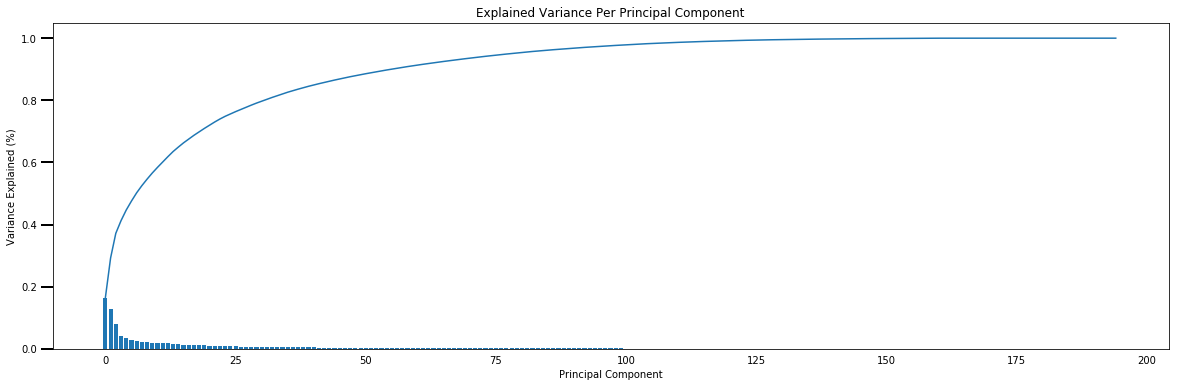

In [25]:
scree_plot(pca)

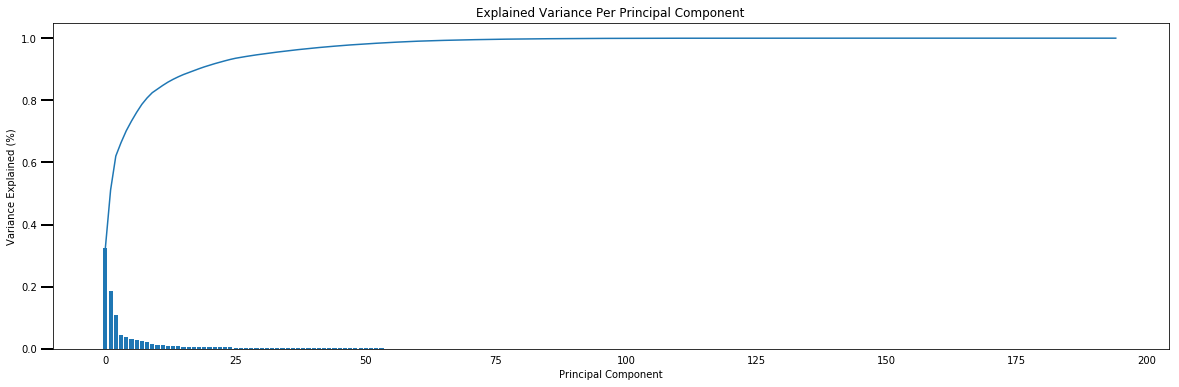

In [26]:
# Special Data
scree_plot(pca_sp)

In [27]:
#PCA
# number of PCA components that explained at least 95% variance ==> 87 components
cumvals = np.cumsum(pca.explained_variance_ratio_)
print("Number of PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

Number of PCA components that explained at least 95% variance : 79


In [28]:
#PCA Special
# number of PCA components that explained at least 90% variance ==> 33 components
cumvals = np.cumsum(pca_sp.explained_variance_ratio_)
print("Number of PCA components that explained at least 95% variance on special data : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

Number of PCA components that explained at least 95% variance on special data : 32


In [29]:
def pca(df, pca_= None):
    """
    return a numpy.ndarray of pca.transform(X)
    """
    from sklearn.decomposition import PCA
    if not pca_:
        pca_ = PCA(0.95)
        pca_.fit(df)

    return pca_.transform(df), pca_


In [30]:
# Re-apply PCA to the data while selecting for number of components to retain.
azdias_pca_sp, pca_sp = pca(azdias_imp_sp)
save(pca_sp, 'pca_special.sav')

azdias_pca, pca = pca(azdias_imp)
save(pca, 'pca.sav')


In [31]:
azdias_pca.shape

(797426, 79)

In [32]:
azdias_pca_sp.shape

(93795, 32)

### Discussion 2.2: Perform Dimensionality Reduction

I choose 79 PCA components that explained at least 95% variance for main data, and 32 components for special data for the same reason.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [114]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,55))
    ax = sns.barplot(weights, features)
    return ax
    

#### Plotting Weight on Azdiaz (main data)

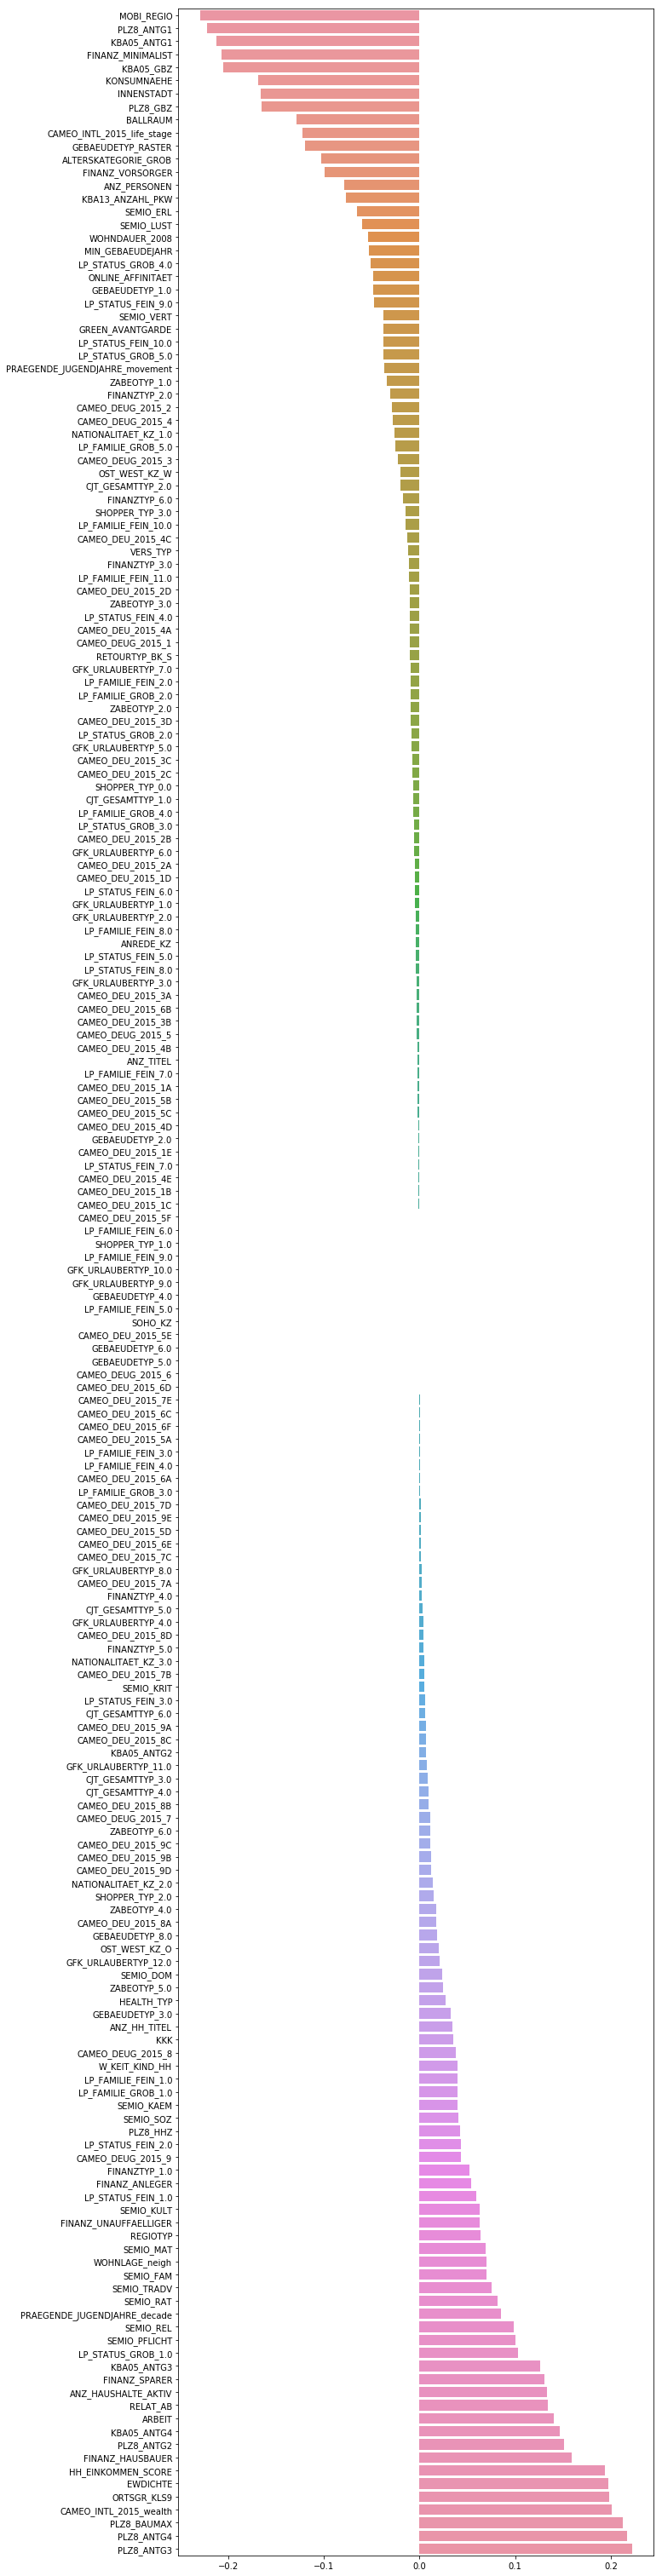

In [277]:
# 1st PCA comp
plot_weight(azdias_imp,pca, 1 )

#### Notes & Interpretations
- Most negative weight features are related to movement paterns, number of 1-2 family houses in the region and microcell, financial typology. 

- Most positive weight features  are related to number of 6-10 or more family houses in the region and wealth typology. 

- The higher value on this component is related to people with poorer houesholds and very low financial interest, while the lower value is related to people with wealthy household and very high financial interest

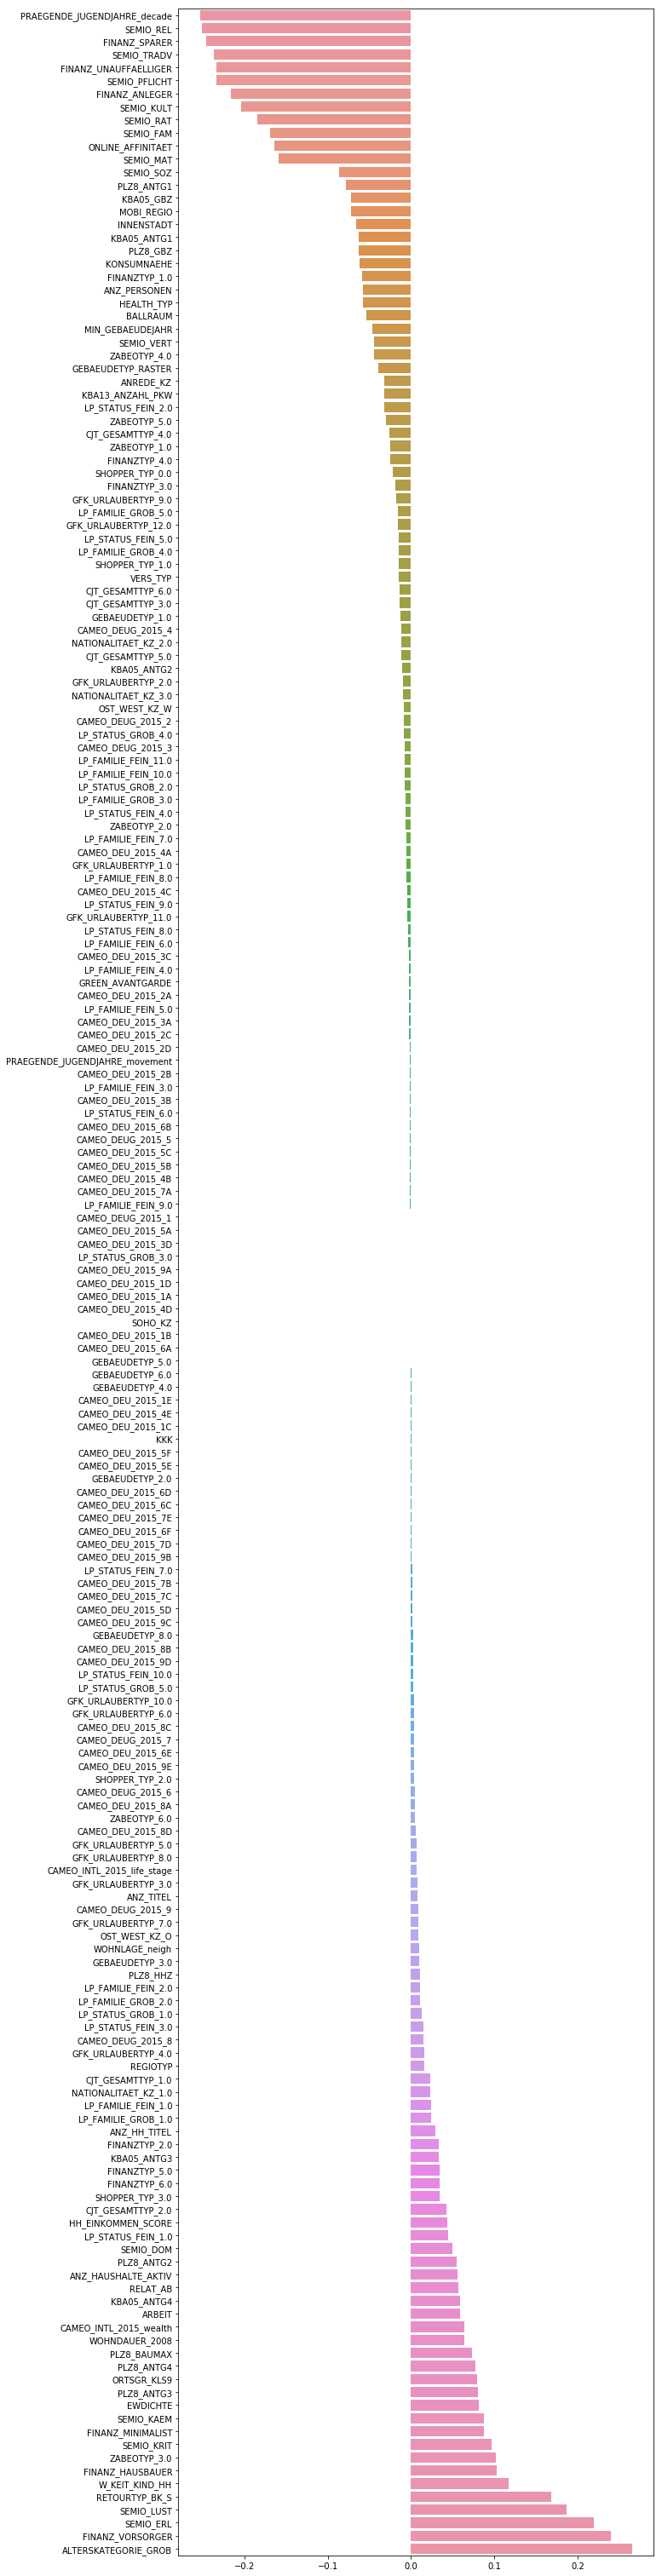

In [278]:
# 2nd PCA comp

plot_weight(azdias_imp,pca, 2 )


#### Notes & Interpretations
- Most negative weight features are  related to person's youth, affinity to religious & traditional minded personality, money-saver financial typology. 

- Most positive weight features are related to age, sensual & event oriented personality. 

- The higher value on this component is related to common older traditional people personality. 

- The lower value on this component is related to the younger people  who are not religious & traditional minded and a money saver type.

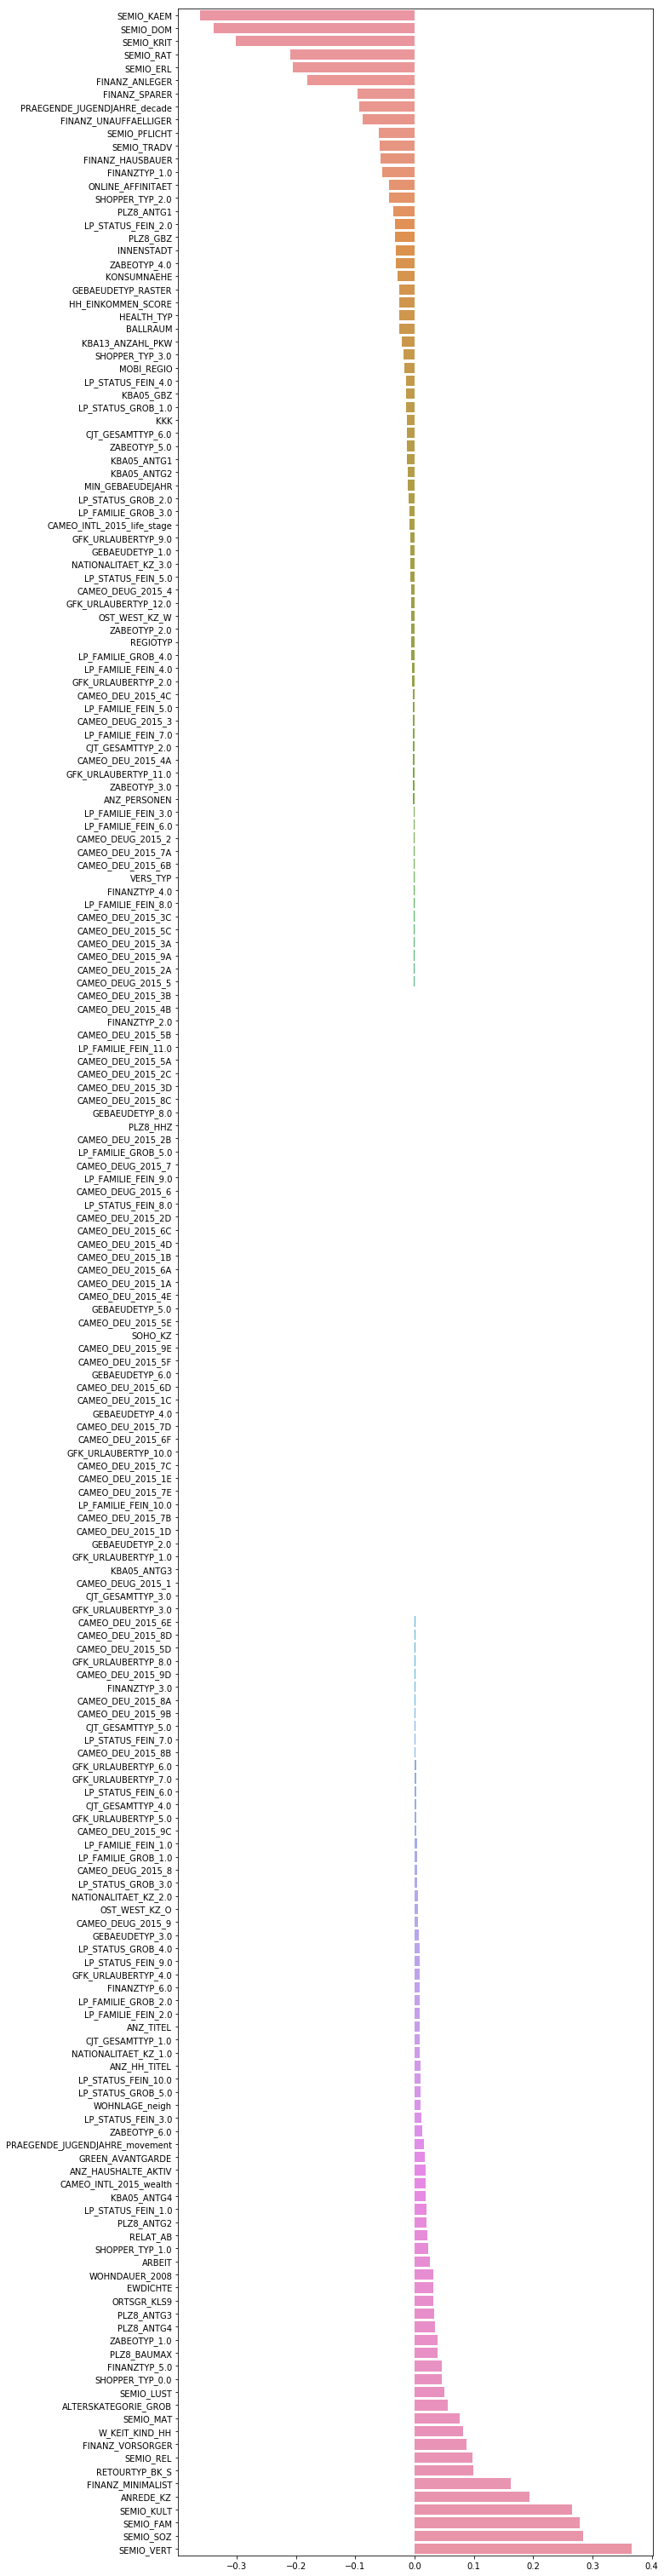

In [279]:
# 3rd PCA comp

plot_weight(azdias_imp,pca, 3 )

#### Notes & Interpretations
- Most negative weight features are  related to personality typology of combative attitude, dominant minded, critical-minded, rational. 

- Most positive weight features are related to personality typology of dreamful, socially & family minded. 

- The higher value on this component is related to the people who are not socially & family minded, and likely to be a rational, critical, dominant minded with combative attitude.

- The lower value on this component is related to the people who are not rational & critical minded, and likely to be a socially & family minded.

#### Plotting weight for azdias special data

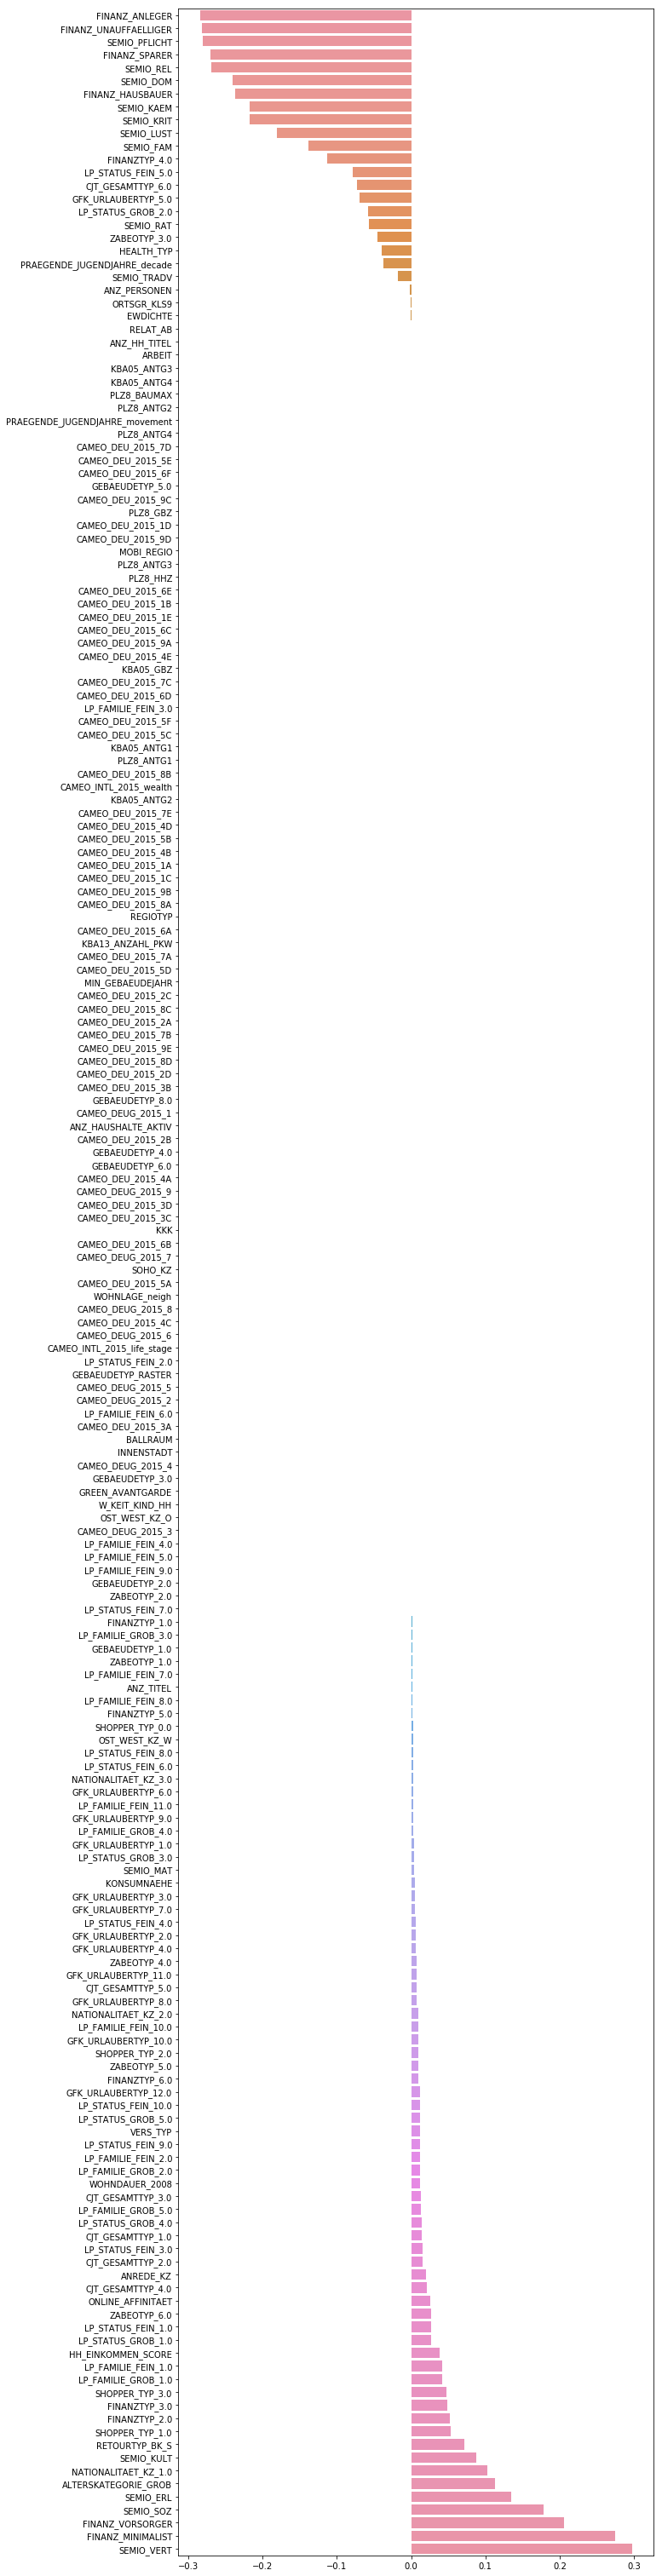

In [280]:
# 1st PCA comp
plot_weight(azdias_imp_sp,pca_sp, 1 )

#### Notes & Interpretations
- Most negative weight features are  related to dutiful & religious personality typology, money-saver & investor financial typology.

- Most positive weight features are related to dreamful & socially-minded personality typology, financial interest typology. 

- The higher value on this component is related to the people who are not socially minded with very high interest on financial.

- The lower value on this component is related to the people who are not a dutiful & religious personality, and not a money saver or investor type of people, but likely to be a high socially minded.

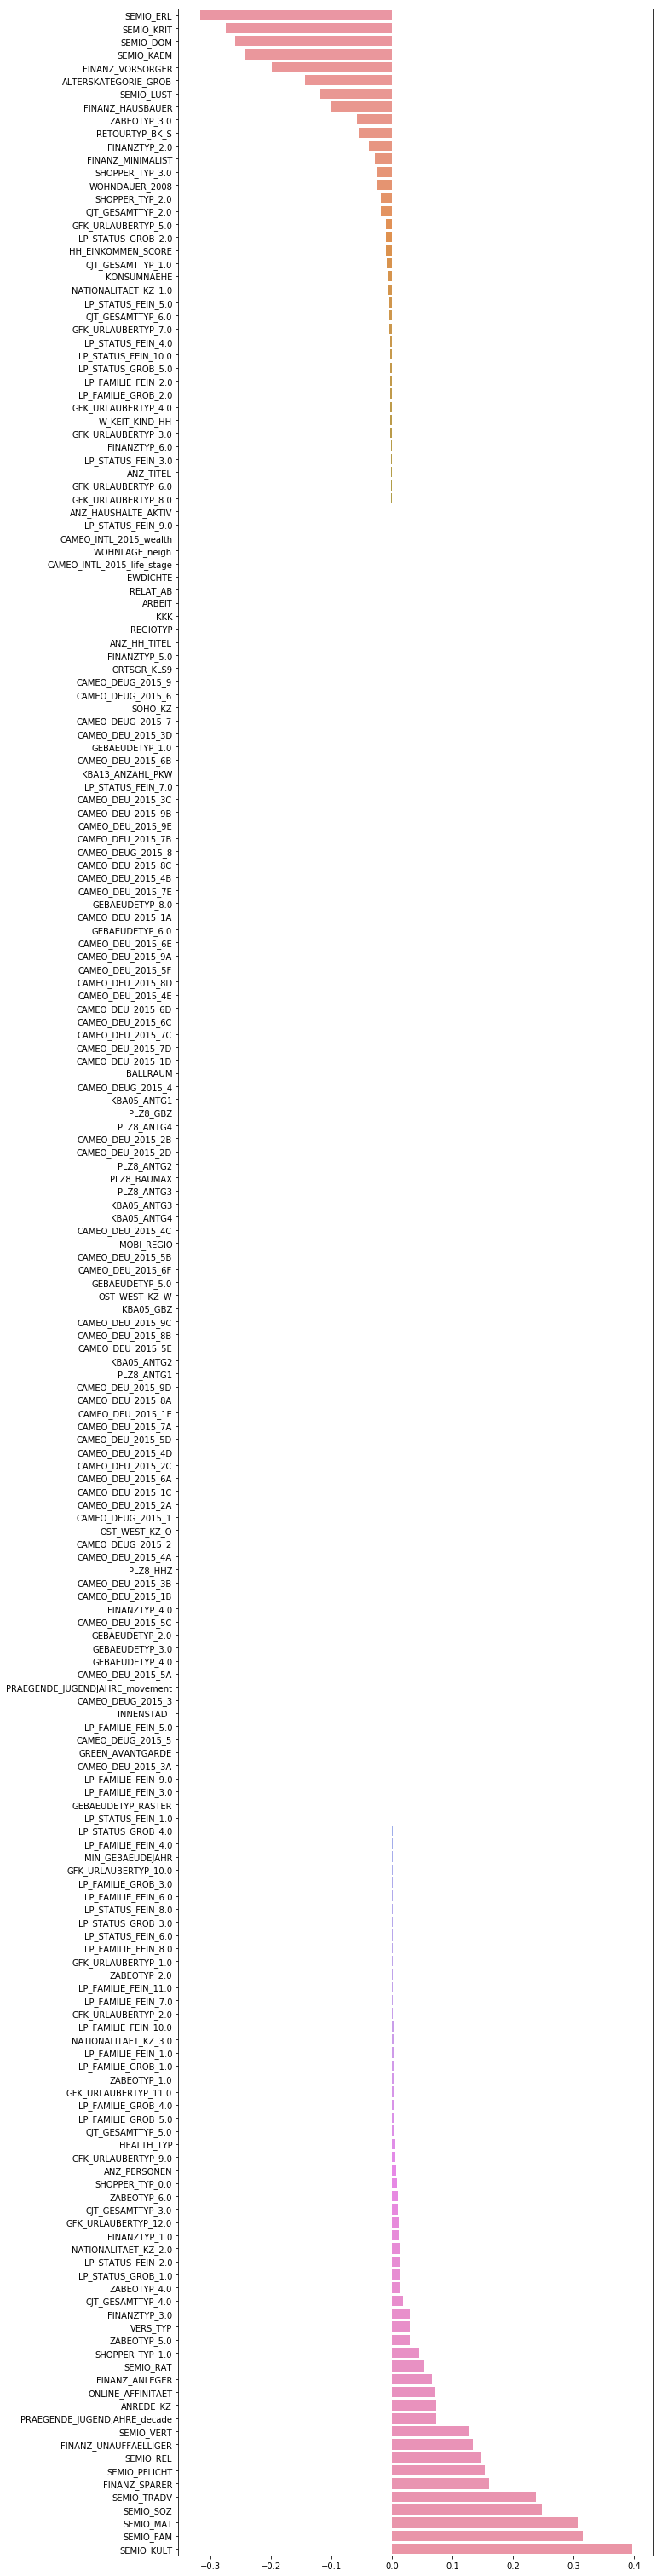

In [281]:
# 2nd PCA comp
plot_weight(azdias_imp_sp,pca_sp, 2 )

#### Notes & Interpretations
- Most negative weight features are  related to personality typology of event oriented, combative attitude, dominant minded, critical-minded. 

- Most positive weight features are related to personality typology of traditional, dreamful, socially & family minded. 

- The higher value on this component is related to the people who are not socially & family minded, and likely to be a event oriented critical, dominant minded with combative attitude.

- The lower value on this component is related to the people who are not rational & critical minded, and likely to be a traditional, socially & family minded.

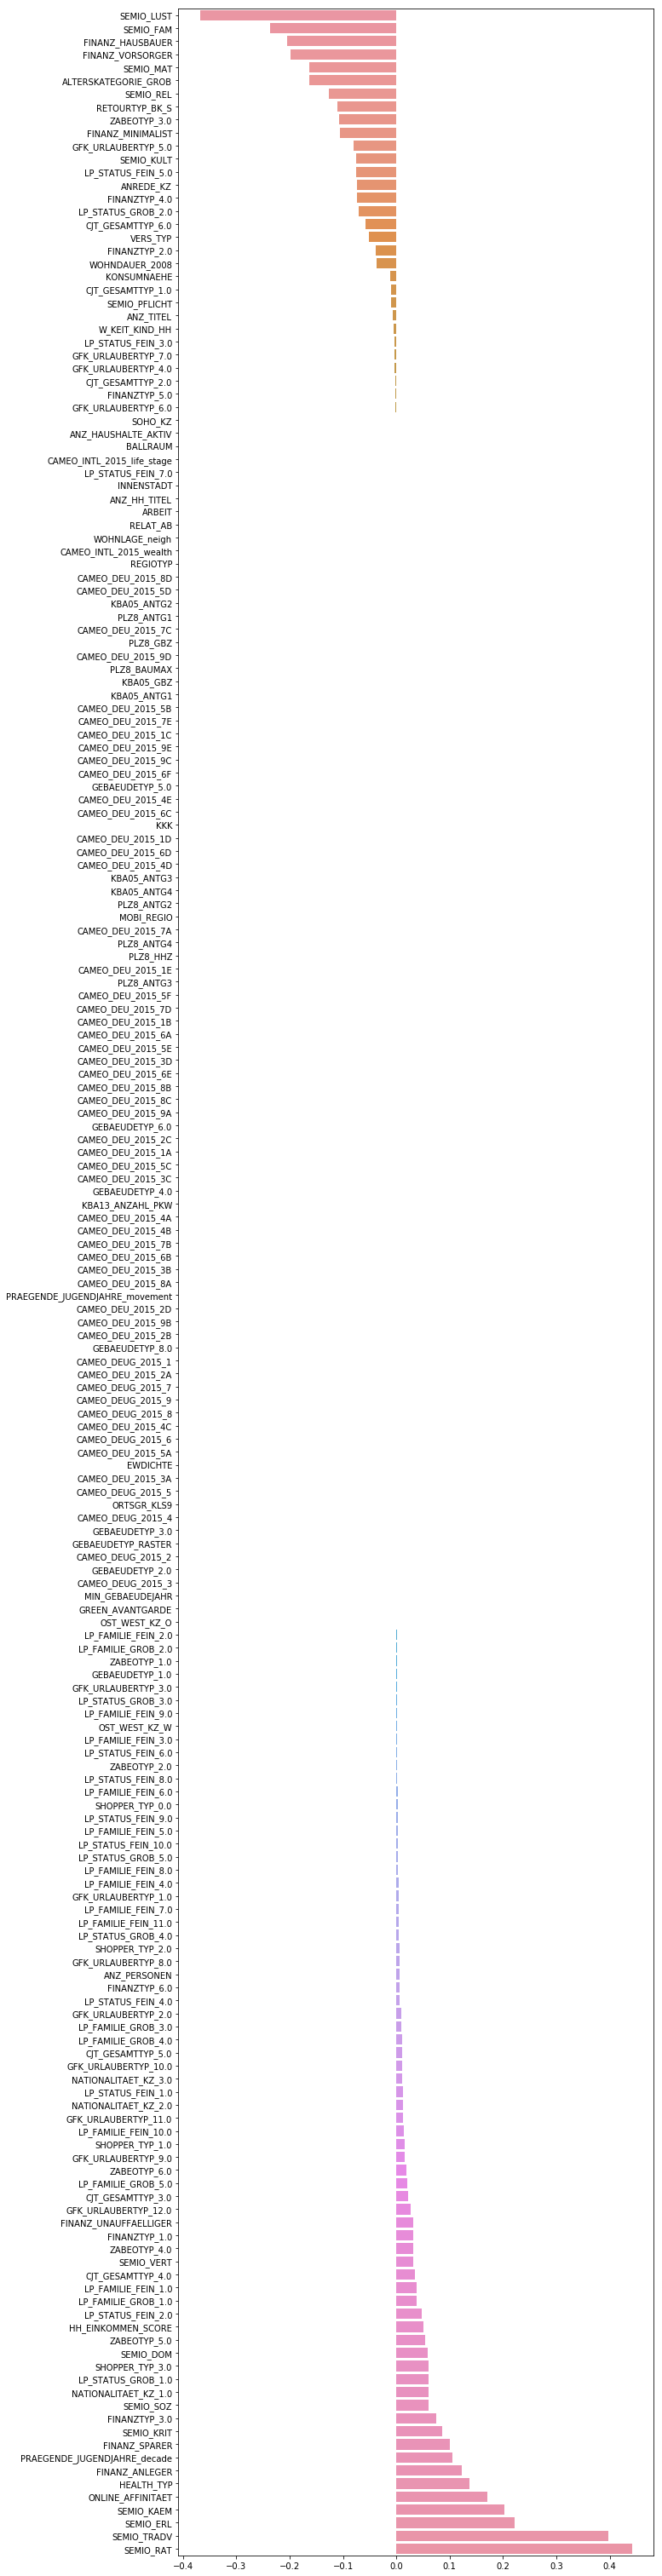

In [282]:
# 3rd PCA comp
plot_weight(azdias_imp_sp,pca_sp, 3 )

#### Notes & Interpretations
- Most negative weight features are  related to sensual, materialistic & family minded personality typology and age typology.

- Most positive weight features are related to personality typology of traditional, rational, combative attitude, event oriented, online affinity. 

- The higher value on this component is related to the younger people who are not traditional, rational & combative attitude, but with very high online affinity, and also likely to be a sensual, materialistic & family minded

- The lower value on this component is related to the older people who are not sensual, materialistic & family minded, but likely to be a traditional and rational minded people.


### Discussion 2.3: Interpret Principal Components

We can interpret positive and negative values in a meaningful way based on most positive and negative weight. Please see details on above notes and interpretation after plotting each weight of components.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

100%|█████████████████████████████████████████| 13/13 [43:04<00:00, 198.83s/it]


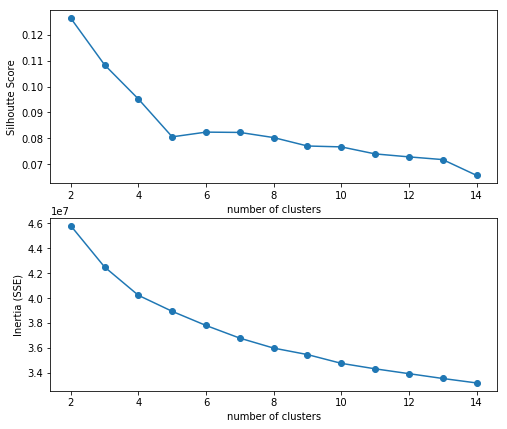

In [33]:
### UPDATE

"""
Azdias data (main)
"""
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

# X = pca.fit_transform(data)
X = azdias_pca
mbk_silh = []
mbk_inertia = []
for n in tqdm(range(2,15)):
    
    model = KMeans(n_clusters = n, random_state=42)
    preds = model.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, preds, sample_size= 40000)
       
    mbk_silh.append(silhouette_avg)
    mbk_inertia.append(model.inertia_)

fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
ax1.plot(range(2,15), mbk_silh,marker="o")
ax1.set_ylabel("Silhoutte Score")
ax1.set_xlabel('number of clusters')
ax2.plot(range(2,15), mbk_inertia, marker="o")
ax2.set_ylabel("Inertia (SSE)")
ax2.set_xlabel("number of clusters")
plt.show()


100%|██████████████████████████████████████████| 13/13 [13:28<00:00, 62.22s/it]


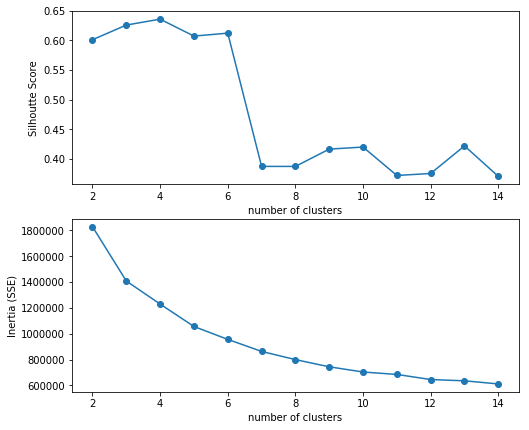

In [34]:
### UPDATE
"""
Azdias Special Data
"""

# X = pca.fit_transform(data)
X = azdias_pca_sp
mbk_silh = []
mbk_inertia = []
for n in tqdm(range(2,15)):
    
    model = KMeans(n_clusters = n)
    preds = model.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, preds, sample_size= 40000)
       
    mbk_silh.append(silhouette_avg)
    mbk_inertia.append(model.inertia_)

fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
ax1.plot(range(2,15), mbk_silh,marker="o")
ax1.set_ylabel("Silhoutte Score")
ax1.set_xlabel('number of clusters')
ax2.plot(range(2,15), mbk_inertia, marker="o")
ax2.set_ylabel("Inertia (SSE)")
ax2.set_xlabel("number of clusters")
plt.show()


In [35]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 7, random_state=42)
preds = kmeans.fit_predict(azdias_pca) 
save(kmeans, 'kmeans.sav')

#azdias special data
kmeans_sp = KMeans(n_clusters = 6, random_state=42)
preds_sp = kmeans_sp.fit_predict(azdias_pca_sp) 
save(kmeans_sp, 'kmeans_special.sav')

In [36]:
#load 
#kmeans = load('kmeans.sav')
preds = kmeans.predict(azdias_pca)

#kmeans_sp = load('kmeans_special.sav')
preds_sp = kmeans_sp.predict(azdias_pca_sp)


### Discussion 3.1: Apply Clustering to General Population

On main azdias data, there were no clear "elbows" observed, the silhoutte score was not strong enough (less than 0.2), it was decreased when number of clusters were increased. I choosed to take 7 clusters when the inertia value was low enough and the sillhouttee score was decreasing after more than 7 clusters.

On azdias special data, there were also no clear "elbows" observed, however the silhoutte score was better (more than 0.6). I choosed to take 5 clusters as the silhoutte score was high enough and significantly decreased after 5 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [37]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')#, error_bad_lines=False)

In [38]:
one_hot_cols = load('one_hot_cols.txt')
customers_clean, customers_sp, _ = clean_data(customers, feat_info, one_hot_cols)

In [39]:
"""
Matching customer features with azdias features, if azdias feature is not available in customer features, 
add that feature to customer data and fill with '0'.
"""
customers_clean = customers_clean.T.reindex(azdias_clean.columns).T.fillna(0)
customers_sp = customers_sp.T.reindex(azdias_clean_sp.columns).T.fillna(0)

In [40]:
customers_clean.shape

(141640, 195)

In [41]:
azdias_clean.shape

(797426, 195)

#### Notes:
Customers['GEBAEUDETYP'] did not have value of '5'.

In [42]:
"""
Perform Scaling
"""

loaded_scalers = load('scalers.sav')
cust_std = standardScaler_transform(customers_clean, loaded_scalers)

#special
loaded_scalers_sp = load('scalers_special.sav')
cust_std_sp = standardScaler_transform(customers_sp, loaded_scalers_sp)

In [43]:
"""
Perform imputing
"""

loaded_imputer = load('imputer.sav')
cust_imp, imputer = impute(cust_std, loaded_imputer)

#special
loaded_imputer_sp = load('imputer_special.sav')
cust_imp_sp, imputer_sp = impute(cust_std_sp, loaded_imputer_sp)

In [44]:
""" 
PCA 
"""
pca = load('pca.sav')
cust_pca = pca.transform(cust_imp)

#special
pca_sp = load('pca_special.sav')
cust_pca_sp = pca_sp.transform(cust_imp_sp)

In [45]:
#main customer data shape
cust_pca.shape

(141640, 79)

In [46]:
#customer special data shape
cust_pca_sp.shape

(50012, 32)

In [47]:
"""
Predict labels on customer data
"""

kmeans= load('kmeans.sav')
cust_labels = kmeans.predict(cust_pca)

#special
kmeans_sp= load('kmeans_special.sav')
cust_labels_sp = kmeans_sp.predict(cust_pca_sp)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [49]:
#UPDATE

# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

"""
Customer & Azdias (population) main data

    creating new df (labels) to summarize data count and its proportion
    for easier plotting in seaborn
"""

#population
azdias_labels = pd.DataFrame()
labels, count = np.unique(preds, return_counts=True)
azdias_labels['labels'] = labels
azdias_labels['count'] = count
azdias_labels['percent'] = azdias_labels['count'] *100 / azdias_labels['count'].sum()
azdias_labels['dataset'] = 'population'

#customers
customer_labels = pd.DataFrame()
labels, count = np.unique(cust_labels, return_counts=True)
customer_labels['labels'] = labels
customer_labels['count'] = count
customer_labels['percent'] = customer_labels['count'] *100 / customer_labels['count'].sum()
customer_labels['dataset'] = 'customer'

#merge = population + customers
labels = pd.concat([azdias_labels, customer_labels], axis=0)
labels.head(10)

labels   count    percent     dataset
0       0  108165  13.564268  population
1       1  110929  13.910883  population
2       2  107107  13.431591  population
3       3   84361  10.579163  population
4       4  133532  16.745378  population
5       5  110688  13.880661  population
6       6  142644  17.888055  population
0       0   18280  12.905959    customer
1       1    1870   1.320249    customer
2       2   15076  10.643886    customer

In [50]:
## UPDATE
"""
Customer & Azdias (population) SPECIAL data:
    creating new df (labels) to summarize data count and its proportion
    for easier plotting in seaborn
"""

#population
azdias_labels_sp = pd.DataFrame()
labels_sp, count_sp = np.unique(preds_sp, return_counts=True)
azdias_labels_sp['labels'] = labels_sp
azdias_labels_sp['count'] = count_sp
azdias_labels_sp['percent'] = azdias_labels_sp['count'] *100 / azdias_labels_sp['count'].sum()
azdias_labels_sp['dataset'] = 'population special'

#customers
customer_labels_sp = pd.DataFrame()
labels_sp, count_sp = np.unique(cust_labels_sp, return_counts=True)
customer_labels_sp['labels'] = labels_sp
customer_labels_sp['count'] = count_sp
customer_labels_sp['percent'] = customer_labels_sp['count'] *100 / customer_labels_sp['count'].sum()
customer_labels_sp['dataset'] = 'customer special'

#merge = population + customers
labels_sp = pd.concat([azdias_labels_sp, customer_labels_sp], axis=0)
labels_sp.head(10)

labels  count    percent             dataset
0       0  74411  79.333653  population special
1       1   6397   6.820193  population special
2       2   3696   3.940509  population special
3       3   2524   2.690975  population special
4       4   3000   3.198465  population special
5       5   3767   4.016206  population special
0       0  46621  93.219627    customer special
1       1   1139   2.277453    customer special
2       2    803   1.605615    customer special
3       3   1211   2.421419    customer special

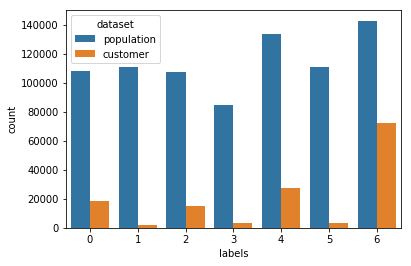

In [51]:
##UPDATE

#plotting data count of azdias (population) and customer data
sns.barplot(x='labels', y='count', hue='dataset', data=labels)

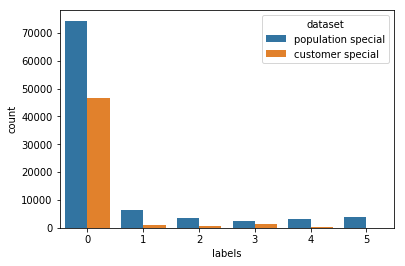

In [52]:
## UPDATE

#plotting data count of azdias (population) and customer SPECIAL data
sns.barplot(x='labels', y='count', hue='dataset', data=labels_sp)

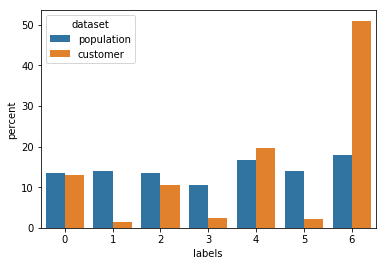

In [53]:
#UPDATE
#plotting data proportion (percent) of azdias (population) and customer data
sns.barplot(x='labels', y='percent', hue='dataset', data=labels)

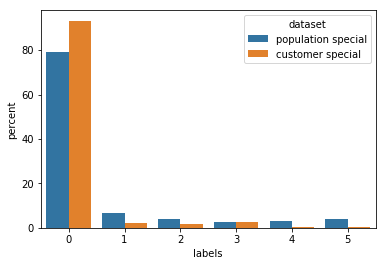

In [54]:
## UPDATE

#plotting data proportion (percent) of azdias (population) and customer SPECIAL data
sns.barplot(x='labels', y='percent', hue='dataset', data=labels_sp)

In [55]:
"""
Main Data :
    Transform centroid back to the original data space with 
    inverse_transform() method of the PCA and StandardScaler objects
"""

centers = kmeans.cluster_centers_
centers_pca = pca.inverse_transform(centers)
centers_std = pd.DataFrame(centers_pca, columns= azdias_std.columns)
centers = centers_std.copy()
for col, scaler in scalers.items():
    centers[col] = scaler.inverse_transform(centers_std[col])
centers

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              3.275489   0.973304           3.318320       1.949294   
1              1.861147   0.400610           1.409024       4.461869   
2              3.476159   0.011592           2.437676       1.891926   
3              1.743008   1.012925           2.816663       4.024587   
4              3.457398   0.058740           3.948121       1.693741   
5              1.843773   0.045743           2.156625       3.976014   
6              3.387497   0.927750           4.622972       1.761874   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          4.200489        1.668400               1.775167          3.538073   
1          2.073045        3.912375               3.698548          4.106730   
2          4.259378        2.238380               1.768615          4.280518   
3          2.166460        3.737949               4.029617          2.505900   
4          4.223453        2.607295               1.995252          2.623804   
5          2.248435        4.295346               3.974247          2.991083   
6          4.216819        1.906571               1.969664          2.064414   

   GREEN_AVANTGARDE  HEALTH_TYP       ...        GEBAEUDETYP_3.0  \
0          0.109706    2.377703       ...               0.329582   
1          0.068314    2.281247       ...               0.363324   
2          0.070078    1.999597       ...               0.310365   
3          0.272850    2.157763       ...               0.179341   
4          0.381690    2.094282       ...               0.124052   
5          0.184157    2.289958       ...               0.162736   
6          0.377505    2.202111       ...               0.137837   

   GEBAEUDETYP_4.0  GEBAEUDETYP_5.0  GEBAEUDETYP_6.0  GEBAEUDETYP_8.0  \
0         0.000687     5.913781e-06         0.000597         0.243518   
1         0.000433     2.889977e-06         0.000420         0.270984   
2         0.000349     1.285908e-06         0.000287         0.238630   
3         0.001146    -6.524864e-07         0.000756         0.181829   
4         0.001672    -5.240616e-07         0.001072         0.132378   
5         0.000911    -1.184730e-06         0.000593         0.174860   
6         0.002155     1.108991e-06         0.001406         0.127052   

   PRAEGENDE_JUGENDJAHRE_decade  PRAEGENDE_JUGENDJAHRE_movement  \
0                      3.591394                        0.115805   
1                      5.543768                        0.086785   
2                      3.419102                        0.081491   
3                      5.691551                        0.276231   
4                      3.616905                        0.387147   
5                      5.528327                        0.194693   
6                      3.573351                        0.380107   

   CAMEO_INTL_2015_wealth  CAMEO_INTL_2015_life_stage  WOHNLAGE_neigh  
0                4.293986                    2.372300        3.376693  
1                4.531205                    1.854111        3.569891  
2                4.250504                    2.655644        3.271649  
3                2.894658                    3.023959        2.992630  
4                2.304745                    3.427899        2.885999  
5                2.700406                    3.125048        2.961617  
6                2.301865                    3.403788        2.905332  

[7 rows x 195 columns]

In [56]:
"""
Special Data :
    Transform centroid back to the original data space with 
    inverse_transform() method of the PCA and StandardScaler objects
"""

centers_sp = kmeans_sp.cluster_centers_
centers_pca_sp = pca_sp.inverse_transform(centers_sp)
centers_std_sp = pd.DataFrame(centers_pca_sp, columns= azdias_std_sp.columns)
centers_sp = centers_std_sp.copy()
for col, scaler in scalers_sp.items():
    centers_sp[col] = scaler.inverse_transform(centers_std_sp[col])
centers_sp

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              2.350204   0.471295           2.993704       4.003759   
1              3.423962  -0.000738           4.120211       1.882798   
2              2.977693   1.006174           4.792793       2.352781   
3              3.990563   0.997148           4.882997       1.369557   
4              1.536546   0.996174           3.680985       3.894785   
5              1.547546  -0.004761           2.819132       3.929654   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          2.999627        4.998056               4.998393          2.991199   
1          4.250356        3.281852               3.102826          2.036749   
2          3.831002        3.069645               3.354658          1.259016   
3          4.721926        1.614431               2.833736          1.843401   
4          2.558483        4.106875               4.601926          1.454288   
5          2.490376        4.671292               4.621679          1.932013   

   GREEN_AVANTGARDE  HEALTH_TYP       ...        GEBAEUDETYP_3.0  \
0          0.000039    1.827548       ...               0.000596   
1          0.002625    1.830226       ...               0.001566   
2          0.002120    1.589503       ...               0.001482   
3          0.003018    1.031646       ...               0.007160   
4          0.004324    1.962054       ...               0.001955   
5          0.002622    2.491020       ...               0.005106   

   GEBAEUDETYP_4.0  GEBAEUDETYP_5.0  GEBAEUDETYP_6.0  GEBAEUDETYP_8.0  \
0        -0.000006              0.0         0.000013         0.000093   
1         0.000295              0.0         0.000812         0.000600   
2         0.000909              0.0         0.000638         0.000297   
3         0.001125              0.0         0.000954         0.001112   
4         0.000789              0.0         0.000493         0.000443   
5         0.000520              0.0         0.000149         0.001600   

   PRAEGENDE_JUGENDJAHRE_decade  PRAEGENDE_JUGENDJAHRE_movement  \
0                      4.384192                        0.004130   
1                      3.824115                        0.003778   
2                      4.188350                        0.003055   
3                      3.380310                        0.004643   
4                      5.335982                        0.005473   
5                      5.327410                        0.004042   

   CAMEO_INTL_2015_wealth  CAMEO_INTL_2015_life_stage  WOHNLAGE_neigh  
0                2.600787                    2.999876        1.882238  
1                2.604632                    3.003688        1.889147  
2                2.598209                    2.996186        1.888921  
3                2.601636                    3.003293        1.880020  
4                2.598325                    3.000363        1.877810  
5                2.600906                    2.997428        1.874655  

[6 rows x 195 columns]

### Analysis on Main Data

#### PCA 1

In [57]:
# print out the cluster label and 1st PCA components center value

for cluster in range(7):
    print(cluster, kmeans.cluster_centers_[cluster][0])


0 2.210897069655307
1 5.10222568466493
2 1.9597020553225655
3 -0.20323603090665518
4 -3.4110605004241528
5 -0.5550131137929281
6 -3.3721876042682823


In [59]:
"""
Over represented
"""
pca1_cols = ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA05_ANTG1', 'FINANZ_MINIMALIST',
            'ORTSGR_KLS9', 'CAMEO_INTL_2015_wealth', 'PLZ8_ANTG4', 'PLZ8_ANTG3']
print('PCA 1')
centers.loc[[4,6],pca1_cols]

PCA 1


MOBI_REGIO  PLZ8_ANTG1  KBA05_ANTG1  FINANZ_MINIMALIST  ORTSGR_KLS9  \
4    4.038489    2.874637     2.510470           3.948121     4.034172   
6    4.045231    2.883595     2.507088           4.622972     3.993648   

   CAMEO_INTL_2015_wealth  PLZ8_ANTG4  PLZ8_ANTG3  
4                2.304745    0.257767    0.957572  
6                2.301865    0.248945    0.939007

In [60]:
"""
Under-represented
"""

pca1_cols = ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA05_ANTG1', 'FINANZ_MINIMALIST',
            'ORTSGR_KLS9', 'CAMEO_INTL_2015_wealth', 'PLZ8_ANTG4', 'PLZ8_ANTG3']
print('PCA 1')
centers.loc[[0,1,2,3,5],pca1_cols]

PCA 1


MOBI_REGIO  PLZ8_ANTG1  KBA05_ANTG1  FINANZ_MINIMALIST  ORTSGR_KLS9  \
0    1.867731    1.560375     0.433044           3.318320     6.790790   
1    1.565306    1.272655     0.259683           1.409024     7.315186   
2    1.829706    1.602218     0.433633           2.437676     6.595769   
3    3.354848    2.593704     1.839920           2.816663     4.531622   
5    3.543875    2.722245     2.000520           2.156625     4.319785   

   CAMEO_INTL_2015_wealth  PLZ8_ANTG4  PLZ8_ANTG3  
0                4.293986    1.184158    2.311446  
1                4.531205    1.457577    2.567241  
2                4.250504    1.156991    2.273993  
3                2.894658    0.420208    1.260204  
5                2.700406    0.347403    1.136036

#### Notes :
- Over represent : 
    - Cluster 4 & 6 are people with low movement, high financial interest with propsperous household

- Under represent :
    - Cluster 2,1,0 are people with high movement, low financial interest with comfortable to less affluent household
    - Cluster 5,3 are properous household with low financial interest

#### PCA 2

In [61]:
for cluster in range(7):
    print(cluster, kmeans.cluster_centers_[cluster][1])


0 1.992734238705338
1 -1.6639777370449296
2 3.9033101608221767
3 -4.294713663739396
4 1.670413806770517
5 -2.9976074248867315
6 0.1544119184079222


In [63]:
"""
Over-represented
"""

pca2_cols = ['PRAEGENDE_JUGENDJAHRE_decade', 'SEMIO_REL','FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER',
            'SEMIO_PFLICHT',
            'RETOURTYP_BK_S', 'SEMIO_LUST', 'SEMIO_ERL', 'FINANZ_VORSORGER', 'ALTERSKATEGORIE_GROB']
print('PCA 2')
centers.loc[[4,6],pca2_cols]

PCA 2


PRAEGENDE_JUGENDJAHRE_decade  SEMIO_REL  FINANZ_SPARER  \
4                      3.616905   2.106264       1.693741   
6                      3.573351   3.728207       1.761874   

   FINANZ_UNAUFFAELLIGER  SEMIO_PFLICHT  RETOURTYP_BK_S  SEMIO_LUST  \
4               1.995252       3.162696        3.429316    4.983569   
6               1.969664       3.151921        3.845987    5.017748   

   SEMIO_ERL  FINANZ_VORSORGER  ALTERSKATEGORIE_GROB  
4   6.416408          4.223453              3.457398  
6   4.223298          4.216819              3.387497

In [64]:
"""
Under-represented
"""
centers.loc[[0,1,2,3,5],pca2_cols]

PRAEGENDE_JUGENDJAHRE_decade  SEMIO_REL  FINANZ_SPARER  \
0                      3.591394   3.866386       1.949294   
1                      5.543768   5.846069       4.461869   
2                      3.419102   2.026698       1.891926   
3                      5.691551   6.256762       4.024587   
5                      5.528327   5.059391       3.976014   

   FINANZ_UNAUFFAELLIGER  SEMIO_PFLICHT  RETOURTYP_BK_S  SEMIO_LUST  \
0               1.775167       3.290596        4.434709    5.018008   
1               3.698548       6.018863        2.745121    3.162305   
2               1.768615       3.009651        4.205347    5.311314   
3               4.029617       5.758848        2.592436    2.914590   
5               3.974247       5.718655        2.579709    3.310623   

   SEMIO_ERL  FINANZ_VORSORGER  ALTERSKATEGORIE_GROB  
0   4.186517          4.200489              3.275489  
1   3.607886          2.073045              1.861147  
2   6.482237          4.259378              3.476159  
3   2.227300          2.166460              1.743008  
5   4.440391          2.248435              1.843773

#### Notes

- Overrepresent : 
    - Cluster 4 & 6 are older people ( 46-60 years old), religious people and high money saver
- Underrepresent : dominate by younger people, and some older religious people. 

#### PCA 3

In [65]:
for cluster in range(7):
    print(cluster, kmeans.cluster_centers_[cluster][2])


0 2.556759659906951
1 -0.4833511550235356
2 -1.5483386667814687
3 2.247820283422671
4 -1.7813063766164277
5 -2.6926507647669102
6 2.0275807489763666


In [66]:
"""
Over-represented
"""

pca3_cols = ['SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_ERL',
'SEMIO_KULT', 'SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_VERT']
print('PCA 3')
centers.loc[[4,6],pca3_cols]

PCA 3


SEMIO_KAEM  SEMIO_DOM  SEMIO_KRIT  SEMIO_ERL  SEMIO_KULT  SEMIO_FAM  \
4    5.645328   5.543415    5.737973   6.416408    1.942186   2.154018   
6    2.695267   3.388733    3.463408   4.223298    4.987509   4.607662   

   SEMIO_SOZ  SEMIO_VERT  
4   2.855569    3.117286  
6   4.673012    6.010618

In [67]:
"""
Under-represented
"""

centers.loc[[0,1,2,3,5],pca3_cols]

SEMIO_KAEM  SEMIO_DOM  SEMIO_KRIT  SEMIO_ERL  SEMIO_KULT  SEMIO_FAM  \
0    2.708315   3.464743    3.841331   4.186517    5.169531   5.193543   
1    4.894180   4.898039    4.513180   3.607886    5.238402   5.094022   
2    6.227973   5.810780    5.815308   6.482237    1.760122   2.162968   
3    2.179417   2.496034    2.562095   2.227300    6.707862   6.779051   
5    5.413476   5.935664    5.528202   4.440391    3.883799   3.655551   

   SEMIO_SOZ  SEMIO_VERT  
0   4.958744    5.841139  
1   4.538540    3.650711  
2   3.246914    2.676464  
3   6.720567    6.301023  
5   2.705713    2.552050

#### Notes
- Cluster 0,3,6 = people who are critical, dominant minded with combative attitude with average social minded
- cluster 1,2,4,5  = people who are high family & social minded with less critical, dominant minded.
- Over-represented: Older & Rich People with high financial interest
  - Cluster 4 : are older people who are family and social minded with prosperous household and high financial interest
  - Cluster 6 : are older people who are critical and dominant minded with prosperous household and high financial interest

- Under-represented: People who have low financial interest
  - Cluster 0 : are older people who are comfortable to less affluent household with low financial interest
  - Cluster 1 : are younger people who are family & social minded with comfortable to less affluen household and low financial interest
  - Cluster 2 : are older people who are family & social minded with comfortable to less affluent household and low financial interest
  - Cluster 3 : are younger people who are critical & dominant minded with prosperous household but low financial interest
  - Cluster 5 : are younger people who are family & social minded with properous household but low financial interest 


### Analysis on Special Data

#### PCA 1

In [68]:
for cluster in range(5):
    print(cluster, kmeans_sp.cluster_centers_[cluster][0])


0 -1.4081448670204313
1 5.5936243726569455
2 7.737215634113458
3 9.292662765231281
4 5.031114200247725


In [69]:
top_neg = ['SEMIO_PFLICHT', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_REL', 'FINANZ_SPARER']

top_pos = ['CAMEO_INTL_2015_wealth','SEMIO_VERT', 'FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'SEMIO_SOZ', 'SEMIO_ERL']
cols =top_neg + top_pos[::-1]
print('PCA 1 Special')
centers_sp[cols]

PCA 1 Special


SEMIO_PFLICHT  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  SEMIO_REL  \
0       4.999711        4.998056               4.998393   6.998577   
1       4.008826        3.281852               3.102826   2.429952   
2       4.038366        3.069645               3.354658   4.077405   
3       3.985217        1.614431               2.833736   2.088018   
4       4.980757        4.106875               4.601926   6.457431   
5       4.989449        4.671292               4.621679   4.938937   

   FINANZ_SPARER  SEMIO_ERL  SEMIO_SOZ  FINANZ_VORSORGER  FINANZ_MINIMALIST  \
0       4.003759   3.010532   2.004090          2.999627           2.993704   
1       1.882798   6.486850   2.667566          4.250356           4.120211   
2       2.352781   3.984255   2.957972          3.831002           4.792793   
3       1.369557   2.969902   2.994756          4.721926           4.882997   
4       3.894785   1.034490   7.046735          2.558483           3.680985   
5       3.929654   4.541967   2.363048          2.490376           2.819132   

   SEMIO_VERT  CAMEO_INTL_2015_wealth  
0    1.013042                2.600787  
1    3.915880                2.604632  
2    6.971414                2.598209  
3    7.072162                2.601636  
4    6.967583                2.598325  
5    2.648098                2.600906

#### Notes:


- Over-represented: prosperous household
    - cluster 0: a very dreamer people, not an investor & money-saver, not a very religious people, average financial interest, social-minded people

- Under-represented: prosperous household
    - Cluster 1 : religious, money-saver, social-minded people
    - Cluster 2 : money-saver, social-minded and not a religious people
    - Cluster 3 : similar to cluster 2 with higher degree in religious and an investor
    - Cluster 4 : similar to cluster 0 with very low social minded & very high on financial interest
    - Cluster 5 : similar to cluster 0 with slightly difference degree on dreamfull and religious affinity


#### PCA 2 Special

In [70]:
for cluster in range(5):
    print(cluster, kmeans_sp.cluster_centers_[cluster][1])


0 -0.047022299475677425
1 -5.978229137196988
2 2.8013679653025667
3 0.2707822197904566
4 8.84839485386255


In [90]:
top_neg = ['SEMIO_ERL', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'FINANZ_VORSORGER']

top_pos = ['SEMIO_KULT', 'SEMIO_FAM', 'SEMIO_MAT', 'SEMIO_SOZ']

cols =top_neg + top_pos[::-1]
print('PCA 2 Special')
centers_sp[cols]

PCA 2 Special


SEMIO_ERL  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  FINANZ_VORSORGER  SEMIO_SOZ  \
0   3.010532    6.990242   5.994657    5.991820          2.999627   2.004090   
1   6.486850    7.029161   5.986732    6.508561          4.250356   2.667566   
2   3.984255    4.222015   2.089013    3.002691          3.831002   2.957972   
3   2.969902    2.870027   2.989605    2.062164          4.721926   2.994756   
4   1.034490    1.118413   1.993416    2.893196          2.558483   7.046735   
5   4.541967    7.024368   5.980739    6.557205          2.490376   2.363048   

   SEMIO_MAT  SEMIO_FAM  SEMIO_KULT  
0   4.997662   5.991261    3.005376  
1   2.933193   1.098015    1.209811  
2   5.981289   5.914068    5.012500  
3   5.997293   5.940082    3.956724  
4   6.015119   7.093460    6.940317  
5   5.545247   4.535106    2.962275

#### Notes:
- Over-represented :
    - Cluster 0 : a social minded, and not a critical & dominant-minded, and also not a people with combative attitude.
- Under-represented :
    - Cluster 4 : a critical & dominant minded with combative attitude and not a social-minded people.
    - Cluster 2 : a dominant & social minded with combative attitude people.
    - Cluster 3 : similar to cluster 2, but more critical minded
    - Cluster 1 : a social, materialistic & family minded but not a critical & dominant-minded people
    - Cluster 5 : similar to cluster 1 but not a materialistic & family minded people.

#### PCA 3 Special

In [111]:
for cluster in range(5):
    print(cluster, kmeans_sp.cluster_centers_[cluster][2])


0 -0.35070374579290425
1 1.9864402112197375
2 0.6663140883687032
3 -5.65930513855914
4 1.0336206803980135


In [112]:
top_neg = ['SEMIO_LUST', 'FINANZ_VORSORGER', 'SEMIO_FAM', 'ALTERSKATEGORIE_GROB', 'SEMIO_MAT']

top_pos = ['SEMIO_RAT', 'SEMIO_TRADV', 'SEMIO_KAEM', 'SEMIO_ERL', 'ONLINE_AFFINITAET']

cols =top_neg + top_pos[::-1]
print('PCA 3 Special')
centers_sp[cols]

PCA 3 Special


SEMIO_LUST  FINANZ_VORSORGER  SEMIO_FAM  ALTERSKATEGORIE_GROB  SEMIO_MAT  \
0    5.000707          2.999627   5.991261              2.350204   4.997662   
1    3.495636          4.250356   1.098015              3.423962   2.933193   
2    2.169818          3.831002   5.914068              2.977693   5.981289   
3    4.972506          4.721926   5.940082              3.990563   5.997293   
4    2.069915          2.558483   7.093460              1.536546   6.015119   
5    2.041632          2.490376   4.535106              1.547546   5.545247   

   ONLINE_AFFINITAET  SEMIO_ERL  SEMIO_KAEM  SEMIO_TRADV  SEMIO_RAT  
0           2.316481   3.010532    5.991820     3.001900   4.005065  
1           2.431790   6.486850    6.508561     2.102109   4.056606  
2           2.708408   3.984255    3.002691     3.928079   4.984515  
3           2.236148   2.969902    2.062164     1.048221   0.958363  
4           3.273839   1.034490    2.893196     5.007400   4.181155  
5           3.326594   4.541967    6.557205     6.437837   5.992792

#### Notes :
- Over-represented:
    - Cluster 0 : middle age (30-45) with a traditional attitude and not a sensual & family & materialistic minded
- Under-represented:
    - Cluster 1 : older age (> 45 ) with family & materialistic & traditional minded people
    - Cluster 2 : older age (> 45) with sensual minded with combative attitude but not a family & materialistic minded people
    - Cluster 3 : similar to cluster 0 but with older age ( > 60), more traditional and combative attitude, and rational people
    - Cluster 4 : younger age (< 30) with sensual and event oriented minded with combative attitude
    - Cluster 5 : similar to cluster 4, younger age (< 30), but not with combative attitude.


#### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

- From main data : Older (> 45 years old) & Rich People with high financial interest
    - Cluster 6 : older people (> 45 years old) who are critical and dominant minded with prosperous household and high financial interest
    - Cluster 4 : are older people (> 45 years old) who are family and social minded with prosperous household and high financial interest
- From special data
  - Cluster 0 special : middle age 30-45, prosperous household, traditional attitude, not critical minded but social minded

#### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

- From main data: People who have low financial interest
    - Cluster 0 : are older people ( > 45 years old) who are comfortable to less affluent household with low financial interest
    - Cluster 1 : are younger people (< 45 years old) who are family & social minded with comfortable to less affluent household and low financial interest
    - Cluster 2 : are older people (> 45 years old) who are family & social minded with comfortable to less affluent household and low financial interest
    - Cluster 3 : are younger people ( < 45 years old) who are critical & dominant minded with prosperous household but low financial interest
    - Cluster 5 : are younger people ( < 45 years old) who are family & social minded with properous household but low financial interest

- From data special: people with prosperous household
    - Cluster 1 : older age (> 45 years old), religious, family & social & materialistic & traditional minded people
    - Cluster 2 : older age (> 45 years old), sensual, combative attitude, dominant, social, money saver
    - Cluster 3 : much older age (> 60 years old), rational & critical minded, traditional with combative attitude
    - Cluster 4 : younger age (< 30 years old), critical & dominant minded with combative attitude and low social minded people.
    - Cluster 5 : younger age (< 30 years old), family-minded and unlikely to have combative attitude and materialistic

### Discussion 3.3: Compare Customer Data to Demographics Data

Segment of population that are relatively popular with the mail-order company are a rich and older people (more than 45 years old) with very high financial interest and critical or social or family minded, and also a middle age (30-45 years old) with prosperous household, traditional & social minded people

Segement of population that are relatively unpopular with the company are people with very low financial interest with comfortable to poorer household. Most of them are younger (less than 45 years old).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.